## Analyse de performances de deux centrales solaires

### Description du projet

L'objectif du projet est d'analyser la performance de deux centrales solaires (centrale 1: FRS00171 et centrale 2: FRS00173) sur plusieurs mois.

1) La première a une puissance crête de 10 377,6 kW et utilise trois pyranomètres pour mesurer l’irradiation à différents endroits de la centrale.
2) La deuxième a une puissance crête de 2 207,48 kW et utilise deux pyranomètres.

Chacune des deux centrales dispose également d’un système de mesure de la production d’énergie.
Les données incluent les mesures prises toutes les 5 minutes pour chaque centrale.

### Import des Libraires et du jeu de données

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.impute import KNNImputer

In [2]:
df = pd.read_csv('Pol_perf_test_data_analyst_V1.csv', sep=';')

In [3]:
df.head()

,Plant_name,Datetime,Pyrano 1(w),Pyrano 2(w),Pyrano 3(w),Production(Wh)
0,FRS00171,01/01/2020 00:05:00,0.466,0.952,0.677,0.0
1,FRS00171,01/01/2020 00:10:00,0.457,0.952,0.670,0.0
2,FRS00171,01/01/2020 00:15:00,0.463,0.952,0.674,0.0
3,FRS00171,01/01/2020 00:20:00,0.455,0.952,0.678,0.0
4,FRS00171,01/01/2020 00:25:00,0.463,0.952,0.677,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315648 entries, 0 to 315647
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Plant_name      315648 non-null  object 
 1   Datetime        315648 non-null  object 
 2   Pyrano 1(w)     299710 non-null  float64
 3   Pyrano 2(w)     299710 non-null  float64
 4   Pyrano 3(w)     197530 non-null  float64
 5   Production(Wh)  299690 non-null  float64
dtypes: float64(4), object(2)
memory usage: 14.4+ MB


La column Datetime n'est pas dans le bon format. Il va falloir la transformer en format datetime pour pouvoir l'utiliser dans les calculs. 

Il y a d données manquantes pour Pyrano 1(W), Pyrano 2(w) et la la production(Wh). 

In [5]:
# La nombre d'observations et période d'observation de la centrale 1 
plant1 = df[df['Plant_name'] == 'FRS00171']

print('Centrale 1')
print(f'Nombre observations: {plant1.shape[0]}')
print(f'Date de début: {plant1["Datetime"].min()}')
print(f'Date de fin: {plant1["Datetime"].max()}')

Centrale 1
Nombre observations: 210528
Date de début: 01/01/2020 00:05:00
Date de fin: 31/12/2021 23:55:00


In [6]:
# La période d'observation de la centrale 2
plant2 = df[df['Plant_name'] == 'FRS00173']

print('Centrale 2')
print(f'Nombre observations: {plant2.shape[0]}')
print(f'Date de début: {plant2["Datetime"].min()}')
print(f'Date de fin: {plant2["Datetime"].max()}')

Centrale 2
Nombre observations: 105120
Date de début: 01/01/2023 00:05:00
Date de fin: 31/12/2023 23:55:00


In [7]:
df[df['Plant_name'] == 'FRS00171'].describe()

,Pyrano 1(w),Pyrano 2(w),Pyrano 3(w),Production(Wh)
count,197530.000000,197530.000000,197530.000000,1.975170e+05
mean,139.391342,59.025799,177.091272,1.426994e+06
std,240.092620,182.593163,281.536026,2.384484e+06
min,-329.887000,0.000000,0.295000,-4.344000e+06
25%,0.332000,0.952000,0.645000,0.000000e+00
50%,2.104000,0.952000,7.370500,0.000000e+00
75%,172.083000,0.952000,237.388250,1.912000e+06
max,1229.573000,1305.994000,1389.573000,8.678000e+06


In [8]:
df[df['Plant_name'] == 'FRS00173'].describe()

,Pyrano 1(w),Pyrano 2(w),Pyrano 3(w),Production(Wh)
count,102180.000000,102180.000000,0.0,1.021730e+05
mean,186.880763,1032.192692,NaN,4.024335e+05
std,277.640462,708.644348,NaN,5.911608e+05
min,-1.700000,0.330000,NaN,0.000000e+00
25%,-0.200000,80.462000,NaN,0.000000e+00
50%,2.900000,1600.000000,NaN,0.000000e+00
75%,323.400000,1600.000000,NaN,7.430000e+05
max,1450.400000,1600.000000,NaN,2.195000e+06


Analysant ces deux tables de statistiques descriptives, on remarque: 
    
1. Le pyranomètre 2 de la centrale 1 a la même valeur (0.952) pour 3 premiers quartiles donc on peut se demander si la centrale était disfonctionnelle.
2. Le pyranomètre 1 de la centrale 2 le premier quartile a une valeur négative mais normalement l'irradiation solaire n'est pas négative donc il s'agit sûrement d'un erreur de mesure.
3. L pyranomètre 2 de la centrale 2 a la même valeur pour les 2 derniers quartiles (1600), donc de nouveau on peut se demander si la centrale était disfonctionnelle. 

### Tranformation du format

In [9]:
#Transformer le format de la colonne Datetime en datetime
df.Datetime = pd.to_datetime(df.Datetime,dayfirst=True)
df.dtypes

Plant_name                object
Datetime          datetime64[ns]
Pyrano 1(w)              float64
Pyrano 2(w)              float64
Pyrano 3(w)              float64
Production(Wh)           float64
dtype: object

### Visualisation de la production au fil du temps

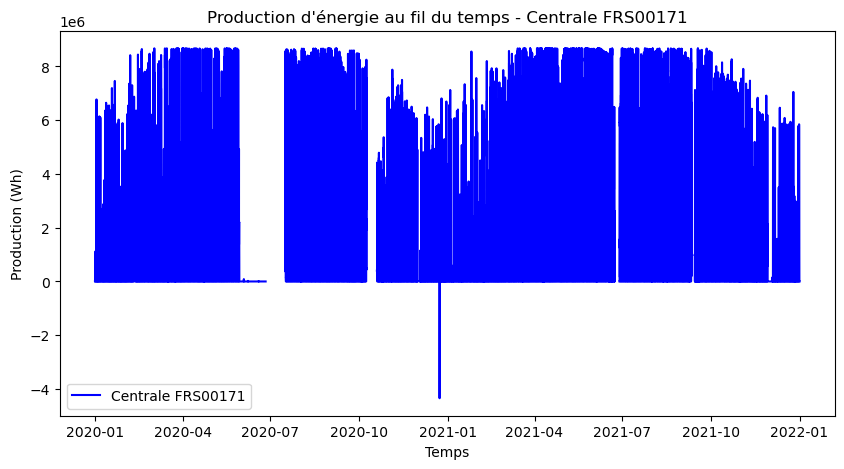

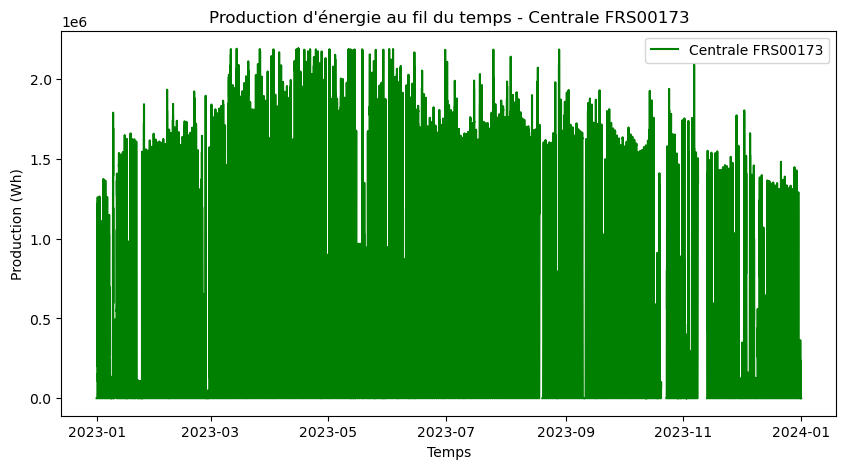

In [10]:
# Filtrer les données pour chaque centrale
centrale_1 = df[df['Plant_name'] == 'FRS00171']
centrale_2 = df[df['Plant_name'] == 'FRS00173']

# Tracer la production d'énergie pour la première centrale
plt.figure(figsize=(10, 5))
plt.plot(centrale_1['Datetime'], centrale_1['Production(Wh)'], label="Centrale FRS00171", color='blue')
plt.title('Production d\'énergie au fil du temps - Centrale FRS00171')
plt.xlabel('Temps')
plt.ylabel('Production (Wh)')
plt.legend()
plt.show()

# Tracer la production d'énergie pour la deuxième centrale
plt.figure(figsize=(10, 5))
plt.plot(centrale_2['Datetime'], centrale_2['Production(Wh)'], label="Centrale FRS00173", color='green')
plt.title('Production d\'énergie au fil du temps - Centrale FRS00173')
plt.xlabel('Temps')
plt.ylabel('Production (Wh)')
plt.legend()
plt.show()

Intervalles de production : La production semble être régulière et élevée la plupart du temps, avec des valeurs atteignant près de 8 millions de Wh (8 MWh).

Périodes de creux ou d'interruptions : On observe des périodes sans production (lacunes dans le graphique), ce qui pourrait être dû à des arrêts planifiés, des problèmes techniques, ou des conditions météorologiques défavorables.

Valeurs négatives : Un pic isolé de production négative est visible autour de début 2021, ce qui peut indiquer une erreur dans la mesure ou dans le traitement des données, car une production négative n’est généralement pas possible dans le cadre d'une centrale solaire.

Tendance globale : À part les interruptions, la production reste relativement stable tout au long de la période, avec quelques fluctuations saisonnières possibles en raison de la variation de l’ensoleillement annuel

### Traitement des doublons de dates heures

In [11]:
def check_for_duplicate_dates(data):
    # Vérifier les doublons dans la colonne 'Datetime'
    duplicates = data[data.duplicated(subset='Datetime', keep=False)]
    
    return duplicates

# Appliquer la fonction pour vérifier les doublons dans les dates pour la centrale 1 (par exemple 'FRS00171')
duplicates = check_for_duplicate_dates(df)

# Afficher les résultats
if not duplicates.empty:
    print("Il y a des doublons dans les dates")
    display(duplicates.head(20))
    display(duplicates.tail(20))
else:
    print("Aucun doublon trouvé dans les dates")

Il y a des doublons dans les dates


,Plant_name,Datetime,Pyrano 1(w),Pyrano 2(w),Pyrano 3(w),Production(Wh)
85835,FRS00171,2020-10-25 02:00:00,NaN,NaN,NaN,NaN
85836,FRS00171,2020-10-25 02:05:00,NaN,NaN,NaN,NaN
85837,FRS00171,2020-10-25 02:10:00,NaN,NaN,NaN,NaN
85838,FRS00171,2020-10-25 02:15:00,NaN,NaN,NaN,NaN
85839,FRS00171,2020-10-25 02:20:00,NaN,NaN,NaN,NaN
85840,FRS00171,2020-10-25 02:25:00,NaN,NaN,NaN,NaN
85841,FRS00171,2020-10-25 02:30:00,NaN,NaN,NaN,NaN
85842,FRS00171,2020-10-25 02:35:00,NaN,NaN,NaN,NaN
85843,FRS00171,2020-10-25 02:40:00,NaN,NaN,NaN,NaN
85844,FRS00171,2020-10-25 02:45:00,NaN,NaN,NaN,NaN


,Plant_name,Datetime,Pyrano 1(w),Pyrano 2(w),Pyrano 3(w),Production(Wh)
297231,FRS00173,2023-10-29 02:20:00,NaN,NaN,NaN,NaN
297232,FRS00173,2023-10-29 02:25:00,NaN,NaN,NaN,NaN
297233,FRS00173,2023-10-29 02:30:00,NaN,NaN,NaN,NaN
297234,FRS00173,2023-10-29 02:35:00,NaN,NaN,NaN,NaN
297235,FRS00173,2023-10-29 02:40:00,NaN,NaN,NaN,NaN
297236,FRS00173,2023-10-29 02:45:00,NaN,NaN,NaN,NaN
297237,FRS00173,2023-10-29 02:50:00,NaN,NaN,NaN,NaN
297238,FRS00173,2023-10-29 02:55:00,NaN,NaN,NaN,NaN
297239,FRS00173,2023-10-29 02:00:00,-0.2,1600.0,NaN,NaN
297240,FRS00173,2023-10-29 02:05:00,0.1,1600.0,NaN,0.0


In [12]:
def handle_datetime_duplicates(data): 
    # Identifier les doublons dans la colonne 'Datetime'
    duplicates = data[data.duplicated(subset='Datetime', keep=False)]
    
    # Supprimer les doublons uniquement si toutes les colonnes 'Pyrano' et 'Production' sont NaN
    nan_duplicates = duplicates[duplicates[['Pyrano 1(w)', 'Pyrano 2(w)', 'Pyrano 3(w)', 'Production(Wh)']].isna().all(axis=1)]
    
    # Supprimer les lignes identifiées comme étant des doublons avec uniquement des NaN
    data_cleaned = data.drop(nan_duplicates.index)
    
    return data_cleaned

# Appliquer la fonction sur l'ensemble du DataFrame
df = handle_datetime_duplicates(df)

# Afficher les résultats
display(df)

,Plant_name,Datetime,Pyrano 1(w),Pyrano 2(w),Pyrano 3(w),Production(Wh)
0,FRS00171,2020-01-01 00:05:00,0.466,0.952,0.677,0.0
1,FRS00171,2020-01-01 00:10:00,0.457,0.952,0.670,0.0
2,FRS00171,2020-01-01 00:15:00,0.463,0.952,0.674,0.0
3,FRS00171,2020-01-01 00:20:00,0.455,0.952,0.678,0.0
4,FRS00171,2020-01-01 00:25:00,0.463,0.952,0.677,0.0
...,...,...,...,...,...,...
315643,FRS00173,2023-12-31 23:40:00,-0.500,1600.000,NaN,0.0
315644,FRS00173,2023-12-31 23:45:00,-0.500,1600.000,NaN,0.0
315645,FRS00173,2023-12-31 23:50:00,-0.800,1600.000,NaN,0.0
315646,FRS00173,2023-12-31 23:55:00,-0.500,1600.000,NaN,0.0


In [13]:
duplicates = check_for_duplicate_dates(df)

# Afficher les résultats
if not duplicates.empty:
    print("Il y a des doublons dans les dates.")
    print(duplicates)
else:
    print("Aucun doublon trouvé dans les dates.")

Aucun doublon trouvé dans les dates.


### Traitement des données manquantes

<Axes: >

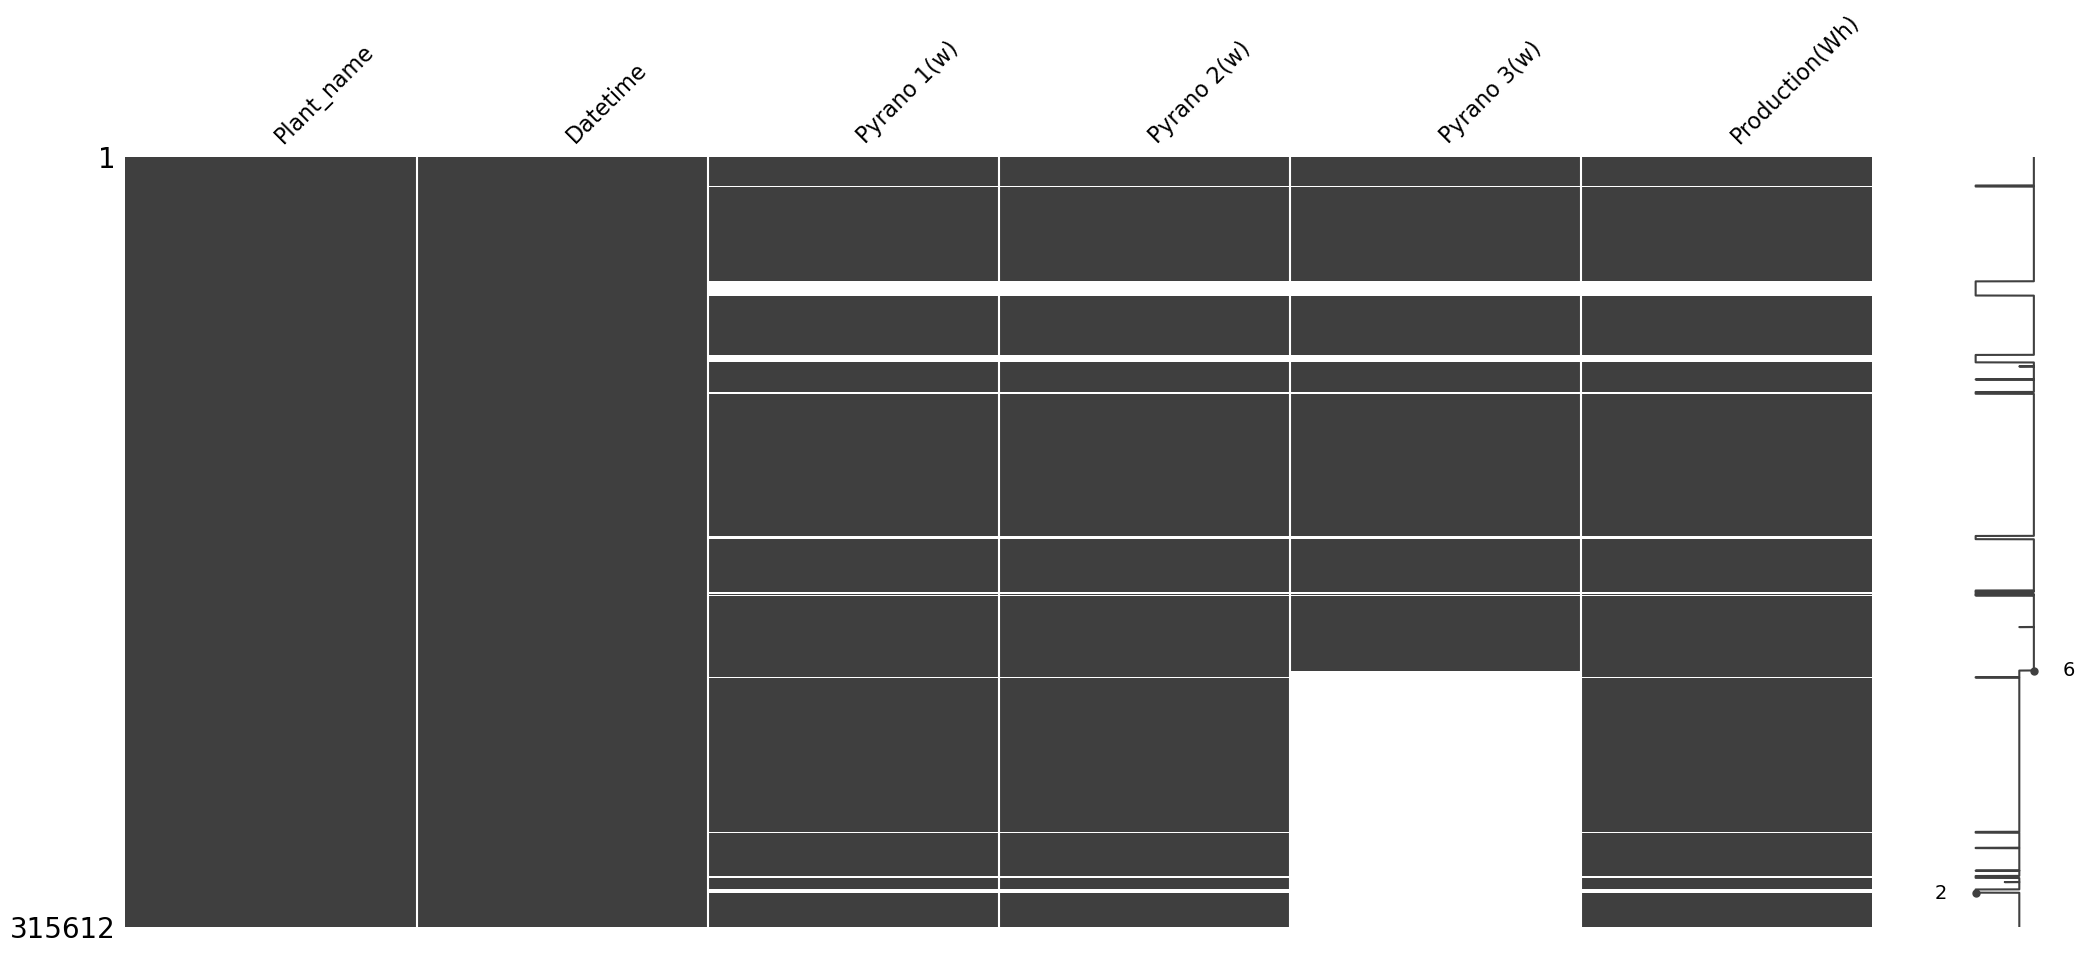

In [14]:
import missingno as msno
msno.matrix(df)

In [15]:
### pourrcentage des données manquantes

data_audit = pd.DataFrame(df.dtypes, columns=["data_type"])
data_audit['missing_data'] = np.round((df.isna().sum() / len(df)) * 100, 2)
data_audit

,data_type,missing_data
Plant_name,object,0.00
Datetime,datetime64[ns],0.00
Pyrano 1(w),float64,5.04
Pyrano 2(w),float64,5.04
Pyrano 3(w),float64,37.41
Production(Wh),float64,5.04


D'une manière générale on peut dire qu'il n'y a pas beaucoup de données manquantes. 

Vu que la production solaire probablement suit une tendance assez stable sur la journée (influencée par le levé du soleil, coucher du soleil, les conditions métérologiques), voir le changement se fait graduellement, on pourra tout à fait envisager de remplir les données manquantes avec du foward filling. 

Mais avant il faut vérifier si certaines données manquent parce que c'est la nuit (pas de soleil). Dans ce cas on peut remplir les données manquantes avec 0. 

Pour cela il faut estimer la période nocturne, plus précisement regarder jusqu'à quelle heure on voit une production élévée. 

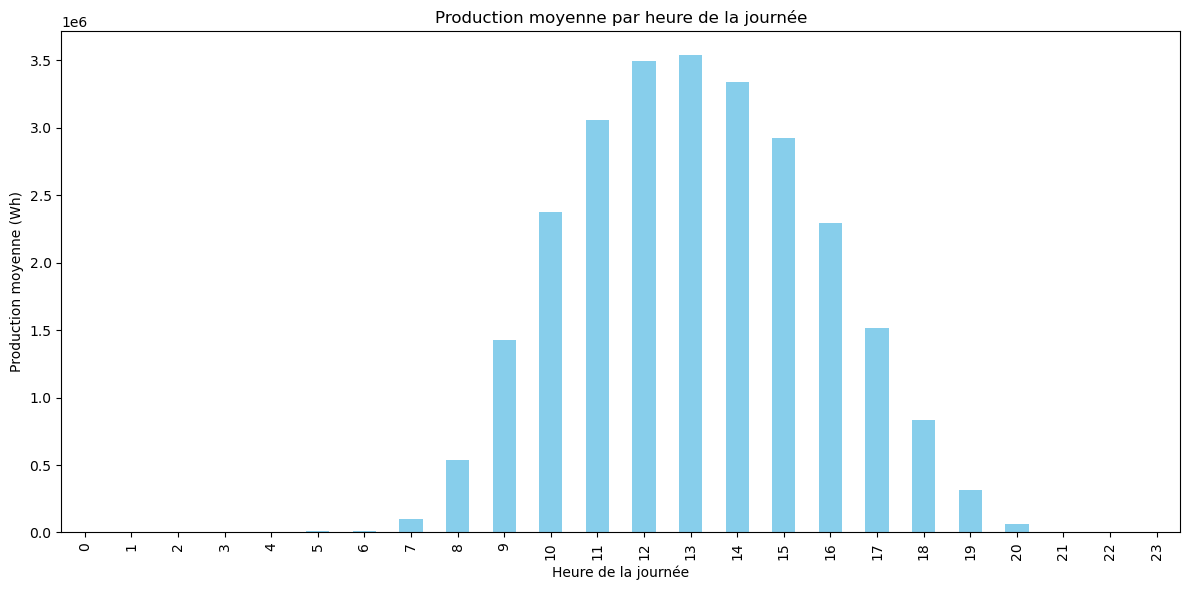

In [16]:
#Estimation de la période nocture en visualisant la production moyenne par horaire

# Extraire l'heure de la colonne 'Datetime' pour analyser la production en fonction de l'heure
df['Hour'] = df['Datetime'].dt.hour

# Grouper par heure et calculer la production moyenne pour chaque heure
hourly_production = df.groupby('Hour')['Production(Wh)'].mean()

# Tracer la production moyenne par heure
plt.figure(figsize=(12, 6))
hourly_production.plot(kind='bar', color='skyblue')
plt.title('Production moyenne par heure de la journée')
plt.xlabel('Heure de la journée')
plt.ylabel('Production moyenne (Wh)')
plt.tight_layout()
plt.show()

D'après le graphique il semble que les centrales produisent surtour entre 21h. Donc notre période nocture sera entre 21h et 6h.

In [17]:
# Function pour traiter les données manquantes la nuit
def night_time_nan_filling(data, number_of_pyranos):

    # Horaires de nuit: 21:00 - 06:00
    night_time = (data['Datetime'].dt.hour >= 21) | (data['Datetime'].dt.hour < 6)

    # Séléction des colonnes basées sur le n° des pyranomètres
    pyrano_columns = ['Pyrano 1(w)', 'Pyrano 2(w)', 'Production(Wh)']
    if number_of_pyranos == 3:
        pyrano_columns.append('Pyrano 3(w)')

    # Imprimer et compter NaNs pendant la nuit
    nan_night_time_count = data.loc[night_time, pyrano_columns].isna().sum()
    print(nan_night_time_count)

    # Remplir les NaNs avec 0 pour les horaires et colonnes précisés 
    data.loc[night_time, pyrano_columns] = data.loc[night_time, pyrano_columns].fillna(0)

    return data

In [18]:
first_plant_data = df[df['Plant_name'] == 'FRS00171']
first_plant_data_filled = night_time_nan_filling(first_plant_data, 3)

second_plant_data = df[df['Plant_name'] == 'FRS00173'] 
second_plant_data_filled = night_time_nan_filling(second_plant_data, 2)

df = pd.concat([first_plant_data_filled, second_plant_data_filled])

df = df.sort_values(by='Datetime')

Pyrano 1(w)       5047
Pyrano 2(w)       5047
Production(Wh)    5054
Pyrano 3(w)       5047
dtype: int64
Pyrano 1(w)       1066
Pyrano 2(w)       1066
Production(Wh)    1071
dtype: int64


In [19]:
""""
def knn_imputer_for_nan_values(data):
    # Définition du imputer
    imputer = KNNImputer(n_neighbors=3)

    # Les colonnes à utiliser
    cols_to_impute = ['Pyrano 1(w)', 'Pyrano 2(w)', 'Production(Wh)']
    data[cols_to_impute] = imputer.fit_transform(data[cols_to_impute])

    
    filter = data['Plant_name'] == 'FRS00171'
    data.loc[filter, ['Pyrano 3(w)']] = imputer.fit_transform(data.loc[filter, ['Pyrano 3(w)']])

    return data
    
df_imputed = knn_imputer_for_nan_values(df)

# Sauvegarder le DataFrame résultant en CSV
df_imputed.to_csv('df_imputed.csv', index=False)
"""

'"\ndef knn_imputer_for_nan_values(data):\n    # Définition du imputer\n    imputer = KNNImputer(n_neighbors=3)\n\n    # Les colonnes à utiliser\n    cols_to_impute = [\'Pyrano 1(w)\', \'Pyrano 2(w)\', \'Production(Wh)\']\n    data[cols_to_impute] = imputer.fit_transform(data[cols_to_impute])\n\n    \n    filter = data[\'Plant_name\'] == \'FRS00171\'\n    data.loc[filter, [\'Pyrano 3(w)\']] = imputer.fit_transform(data.loc[filter, [\'Pyrano 3(w)\']])\n\n    return data\n    \ndf_imputed = knn_imputer_for_nan_values(df)\n\n# Sauvegarder le DataFrame résultant en CSV\ndf_imputed.to_csv(\'df_imputed.csv\', index=False)\n'

In [20]:
df = pd.read_csv('df_imputed.csv')

#Transformer le fomrat de la colonne Datetime en datetime
df.Datetime = pd.to_datetime(df.Datetime)
df.dtypes

Plant_name                object
Datetime          datetime64[ns]
Pyrano 1(w)              float64
Pyrano 2(w)              float64
Pyrano 3(w)              float64
Production(Wh)           float64
Hour                       int64
dtype: object

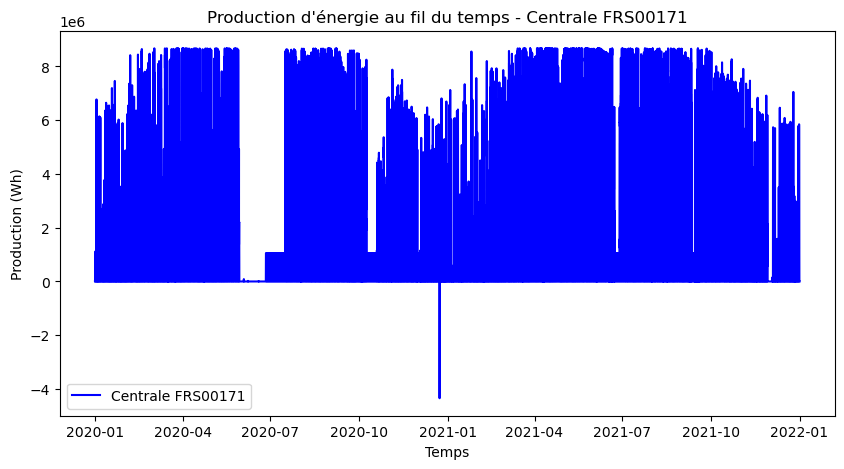

In [21]:
# Filtrer les données pour chaque centrale
centrale_1 = df[df['Plant_name'] == 'FRS00171']
centrale_2 = df[df['Plant_name'] == 'FRS00173']

# Tracer la production d'énergie pour la première centrale
plt.figure(figsize=(10, 5))
plt.plot(centrale_1['Datetime'], centrale_1['Production(Wh)'], label="Centrale FRS00171", color='blue')
plt.title('Production d\'énergie au fil du temps - Centrale FRS00171')
plt.xlabel('Temps')
plt.ylabel('Production (Wh)')
plt.legend()
plt.show()

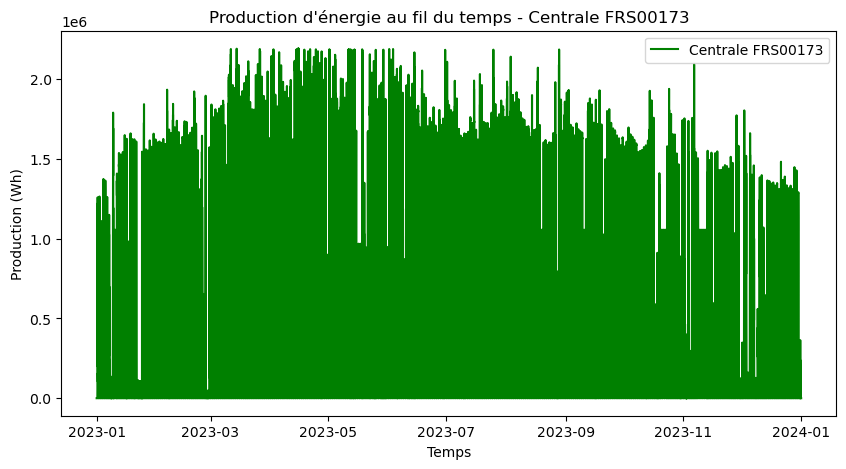

In [22]:
# Tracer la production d'énergie pour la deuxième centrale
plt.figure(figsize=(10, 5))
plt.plot(centrale_2['Datetime'], centrale_2['Production(Wh)'], label="Centrale FRS00173", color='green')
plt.title('Production d\'énergie au fil du temps - Centrale FRS00173')
plt.xlabel('Temps')
plt.ylabel('Production (Wh)')
plt.legend()
plt.show()

Maintenant toutes les valeurs manquantes sont remplies. On peut procéder à l'analyse des valeurs extrèmes. 

### Analyse des données aberrantes

Pour identifier les données aberrantes on peut visualiser la distribution de l'irradiation des pyranos et de la production avec des boxplots.

In [23]:
def draw_boxplots_for_each_variable(data, number_of_pyranos, time=None): 
    # Si le paramètre 'time' est défini, on filtre les données en fonction de l'horaire
    if time == 'Day Time':
        time_filter = (data['Datetime'].dt.hour >= 6) & (data['Datetime'].dt.hour < 21)
        data_filtered = data[time_filter]
    elif time == "Night Time":
        time_filter = (data['Datetime'].dt.hour >= 21) | (data['Datetime'].dt.hour < 6)
        data_filtered = data[time_filter]
    else:
        # Si aucun filtre temporel n'est appliqué, utiliser toutes les données
        data_filtered = data
    
    # Définir les colonnes à prendre en compte
    pyrano_columns = ['Pyrano 1(w)', 'Pyrano 2(w)']
    if number_of_pyranos == 3:
        pyrano_columns.append('Pyrano 3(w)')
     
    # Créer les boxplots pour les pyranomètres
    plt.figure(figsize=(12, 6))
    data_filtered[pyrano_columns].boxplot()
    plt.title(f'Boxplots for Pyranometers ({time if time else "All Times"})')
    plt.tight_layout()
    plt.show()
    
    # Créer le boxplot pour la production
    plt.figure(figsize=(12, 6))
    data_filtered[['Production(Wh)']].boxplot()
    plt.title(f'Boxplots for Production ({time if time else "All Times"})')
    plt.tight_layout()
    plt.show()


 Centrale 1 Jour


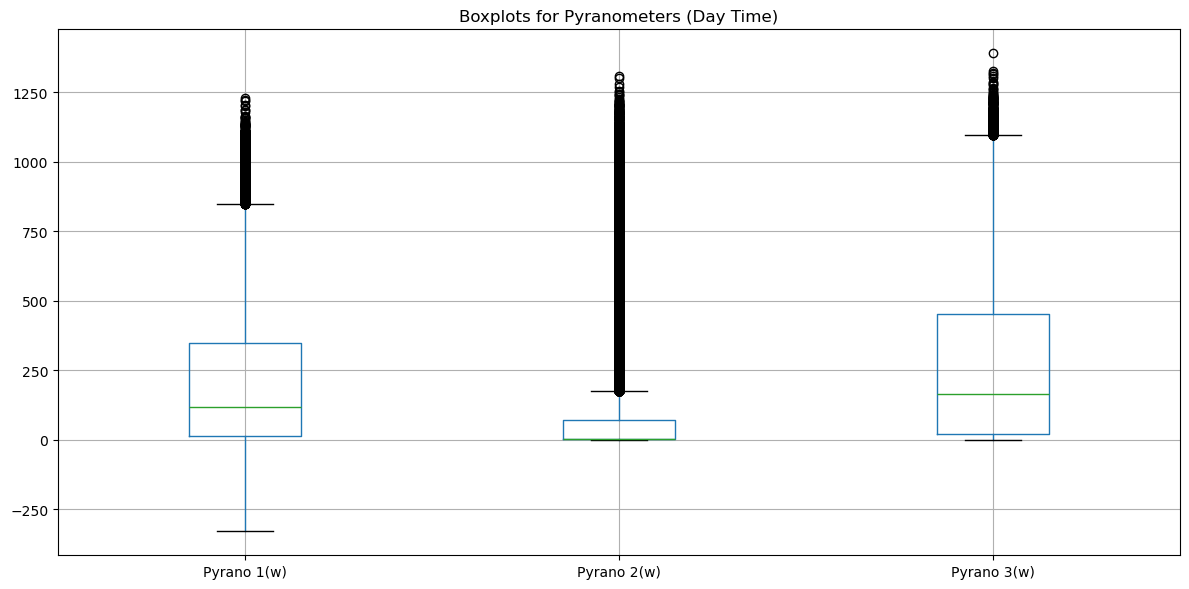

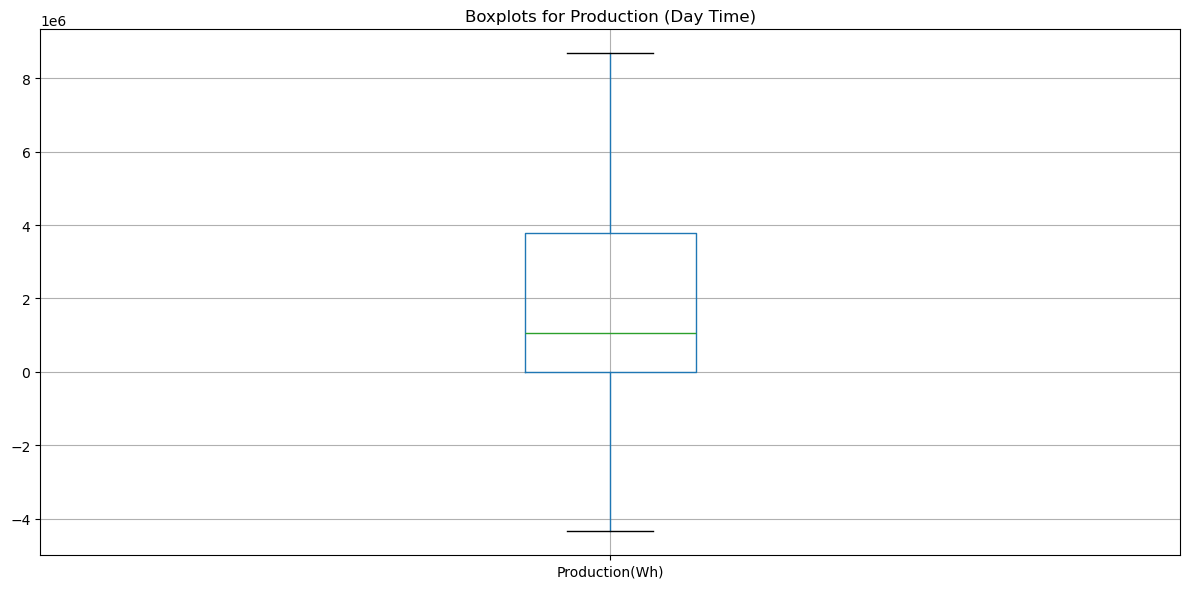

Centrale 1 Nuit


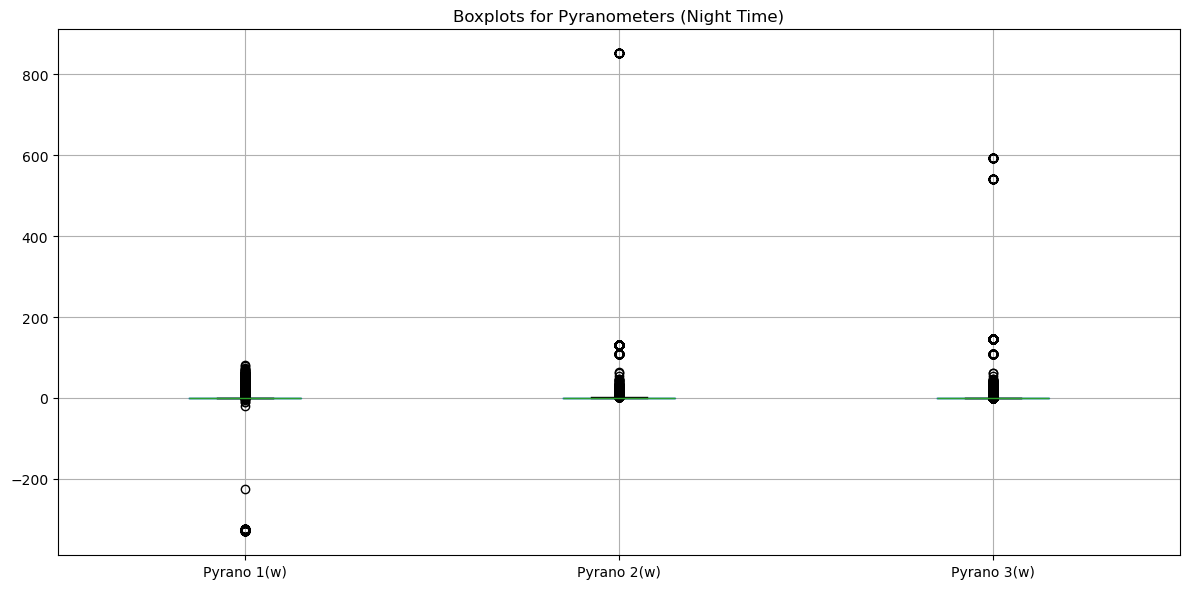

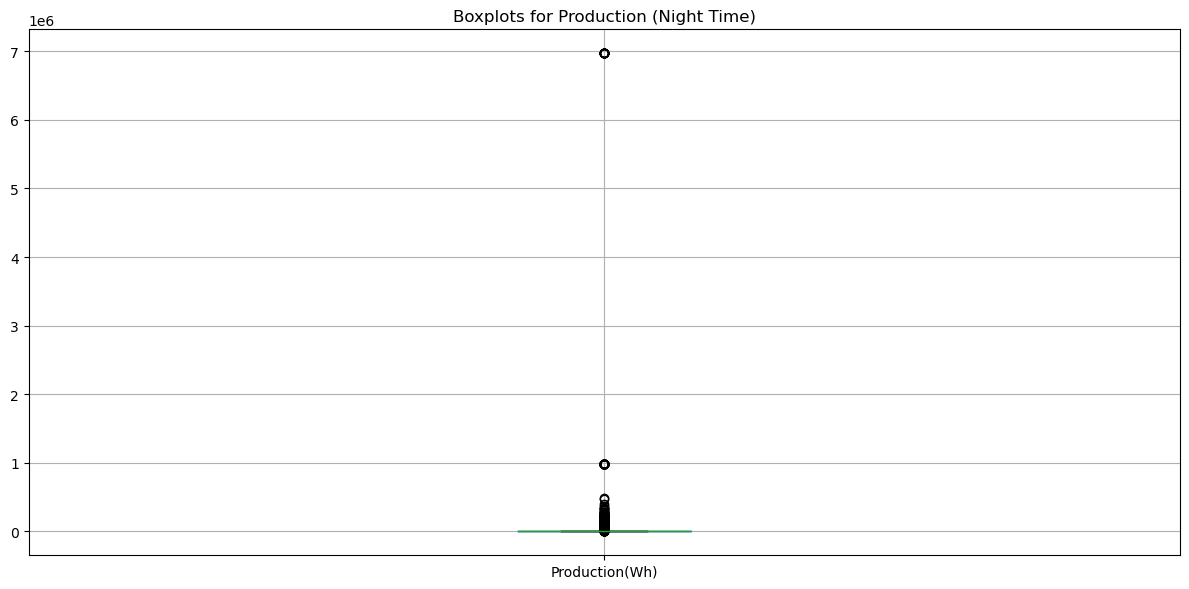

In [24]:
#Boxplots centrale 1

print("\n Centrale 1 Jour")
draw_boxplots_for_each_variable(df[df['Plant_name'] == 'FRS00171'], 3,'Day Time')


print("Centrale 1 Nuit")
draw_boxplots_for_each_variable(df[df['Plant_name'] == 'FRS00171'], 3,'Night Time')


Centrale 2 Jour


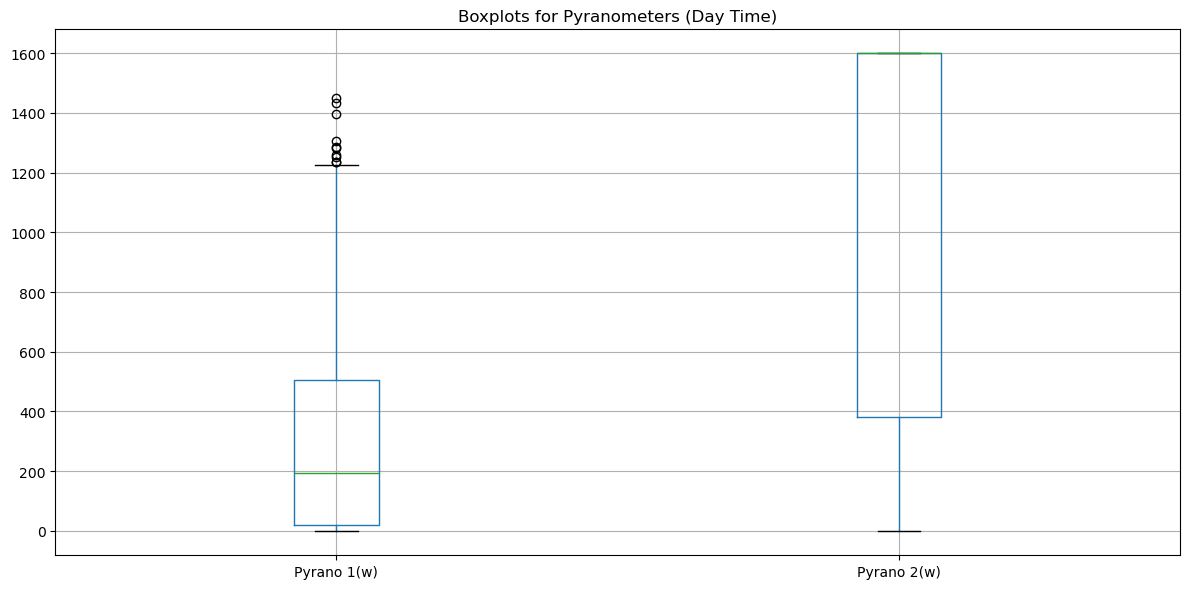

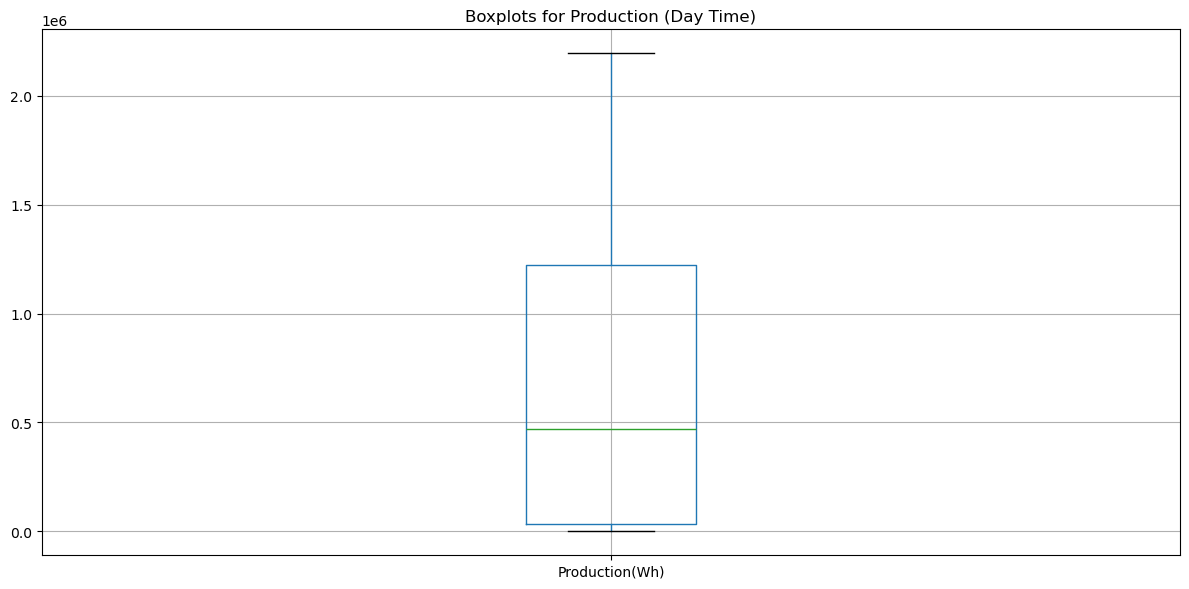

Centrale 2 Nuit


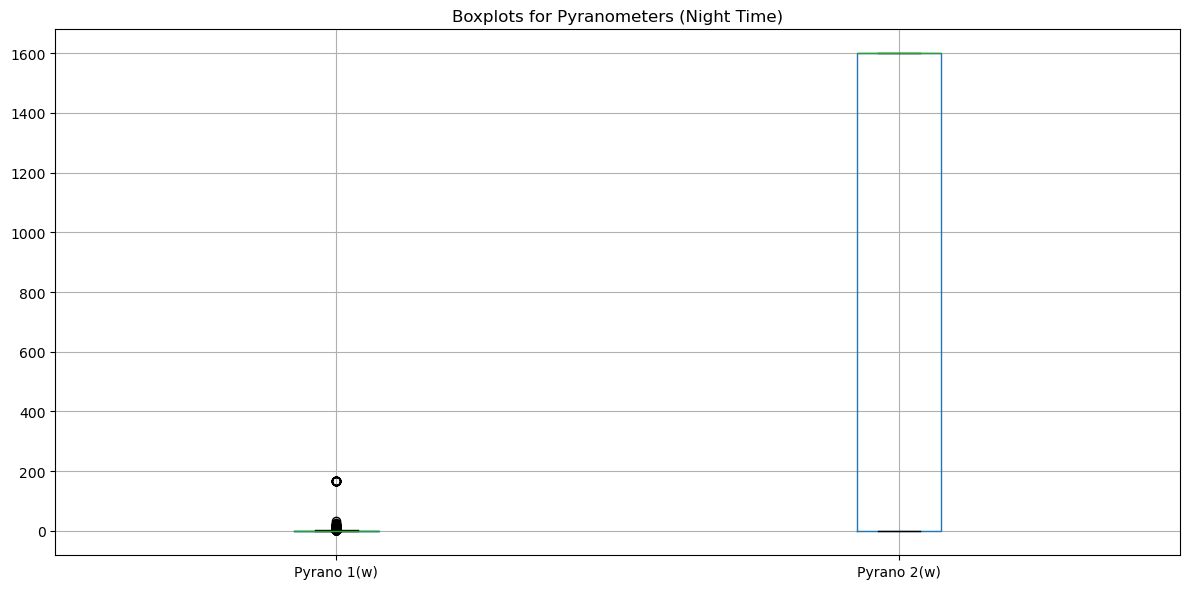

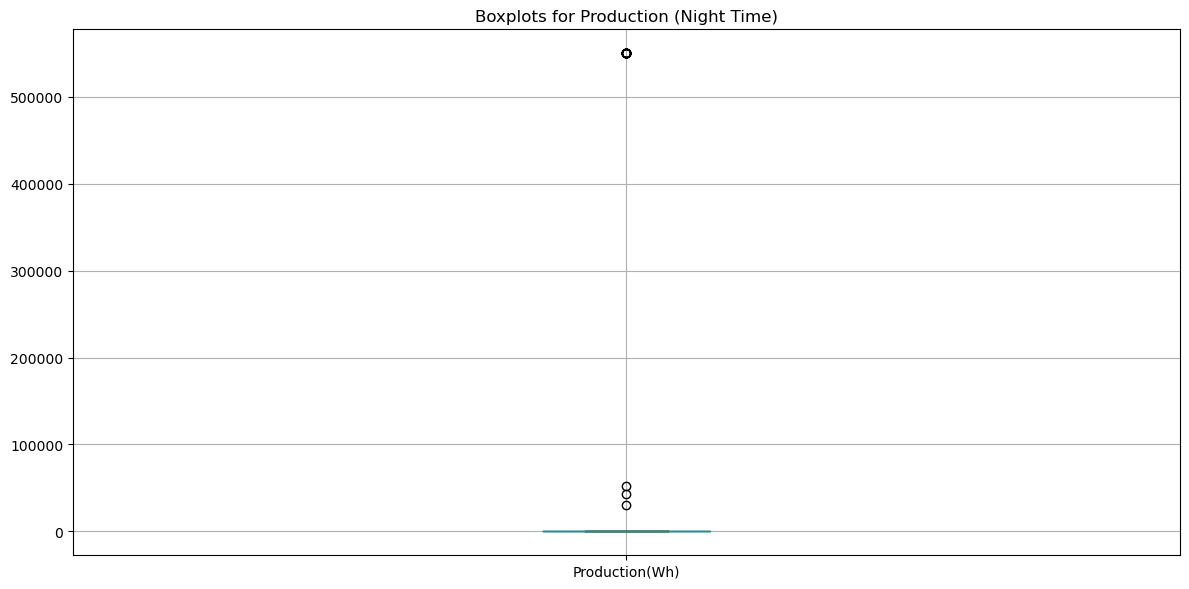

In [25]:
#Boxplots centrale 2

print("\nCentrale 2 Jour")
draw_boxplots_for_each_variable(df[df['Plant_name'] == 'FRS00173'], 2,'Day Time')


print("Centrale 2 Nuit")
draw_boxplots_for_each_variable(df[df['Plant_name'] == 'FRS00173'], 2,'Night Time')

#### Boxplots centrale 1 

Les pyranomètres ont beacuoup de valeurs extrèmes lors de la journée.

Le pyranomètre 1 a des valeurs négatives ce qui n'est pas possible car l'irradiation solaire ne peut pas être négative. On remplacera ces valeurs par la valeur positive la plus proche. Pour les valeurs extrêmes on regardera la distribution de l'irradiation solaire plus en détail. 

Le pyranomètre 2 a beaucoup de valeurs extrèmes. Cela confirme notre remarque du début, les 3 premiers quartiles ont une valeur constante autour de 1. Donc peut-être le pyranomètre n'a pas bien capté la radition solaire car les autres deux pyranomètres montrent beaucoup plus de variation. Il faut une analyse plus approfondie du pyranomètre 2 et soit ne pas le prendre en compte pour la suite, soit interpoler les valeurs à partir des deux autres pyranomètres.

La production diurne a quelques valeurs négatives ce qui n'est pas possible et donc on remplacera ces valeurs par la valeur positive la plus proche. 

La nuit les pyranomètres ont quelques valeurs négatives et positives, on va les remplacer par 0 parce qu'il n'y a ni irradiation solaire négative ni irradiation solaire positive lors de la nuit. 

La production nocturne a quelques valeurs extrêmes qu'on va également remplacer par 0 parce la nuit les centrales solaires ne produisent pas d'énergie normalement. 

#### Boxplots centrale 2

Lors de la journée uniquement le pyranomètre 1 a des valeurs extrêmes. Mais beaucoup moins que la centrale 1. Le pyranomètre 2 ne semble pas avoir de valeurs extrêmes mais il faut garder en tête que les deux derniers quartiles ont la même valeur (1600) et le pyranomètre 1 a des mesures très différents, donc il faut une analyse plus approfondie.

La production diurne n'a pas de valeurs abérrantes.

Par contre la nuit les pyranomètres ont beacoup de valeurs positives qu'on pourra remplacer par 0 car la nuit il n'y a pas d'irradiation de soleil. Pareil pour la production, on pourra remplacer les valeurs positives par 0. 

Mais d'abord on va regarder la distribution de la moyenne et de la mediane de l'irradiation solaire par pyranomètre et par heure.

#### Distribution de la moyenne et de la mediane de l'irradiation solaire par pyranomètre et par heure

#### Centrale 1

In [26]:
def hourly_distribution_of_mean_and_median_solar_radiation(plant_id, pyrano_name):
    # Filtrer les données pour la centrale donnée
    plant_data = df[df['Plant_name'] == plant_id]
    
    # Grouper par heure et calculer l'irradiation médiane et moyenne pour chaque heure
    hourly_mean_radiation = plant_data.groupby('Hour')[pyrano_name].mean()
    hourly_median_radiation = plant_data.groupby('Hour')[pyrano_name].median()
    
    # Créer une figure avec deux sous-graphiques côte à côte
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    
    # Tracer l'irradiation moyenne par heure
    hourly_mean_radiation.plot(kind='bar', ax=axes[0], color='orange')
    axes[0].set_title(f'Radiation solaire moyenne par heure ({pyrano_name})')
    axes[0].set_xlabel('Heure de la journée')
    axes[0].set_ylabel('Radiation solaire moyenne (w)')
    
    # Tracer l'irradiation médiane par heure
    hourly_median_radiation.plot(kind='bar', ax=axes[1], color='skyblue')
    axes[1].set_title(f'Radiation solaire médiane par heure ({pyrano_name})')
    axes[1].set_xlabel('Heure de la journée')
    axes[1].set_ylabel('Radiation solaire médiane (w)')

    # Ajuster la mise en page
    plt.tight_layout()
    plt.show()

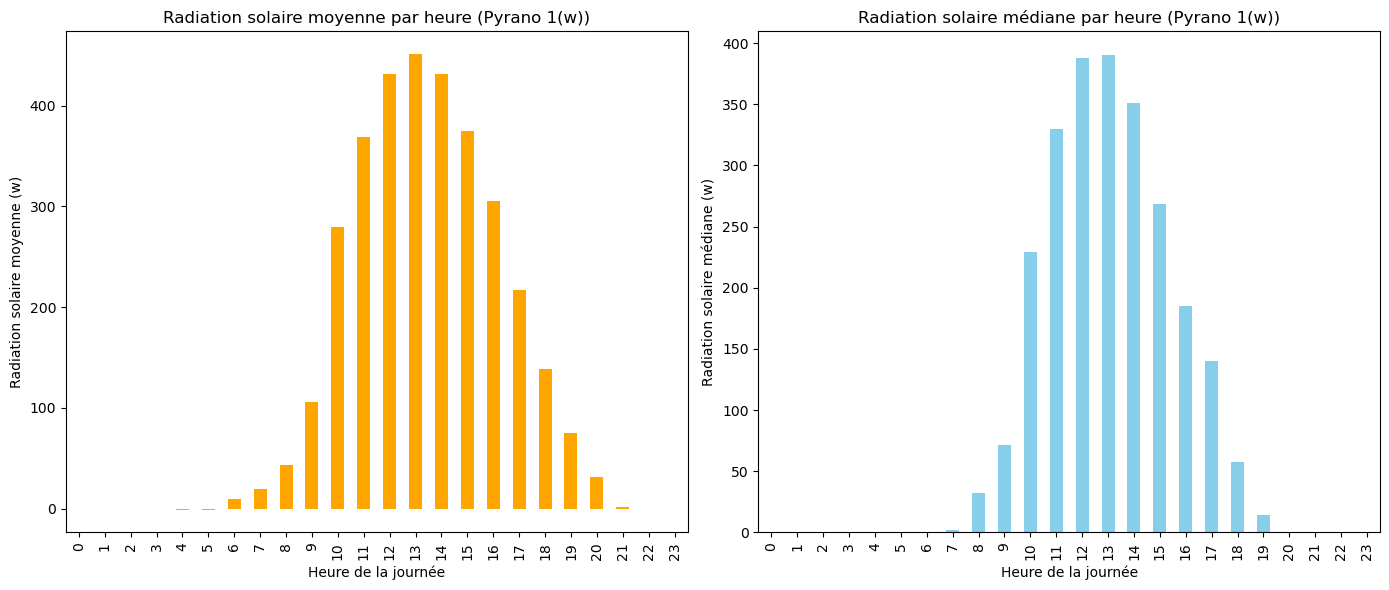

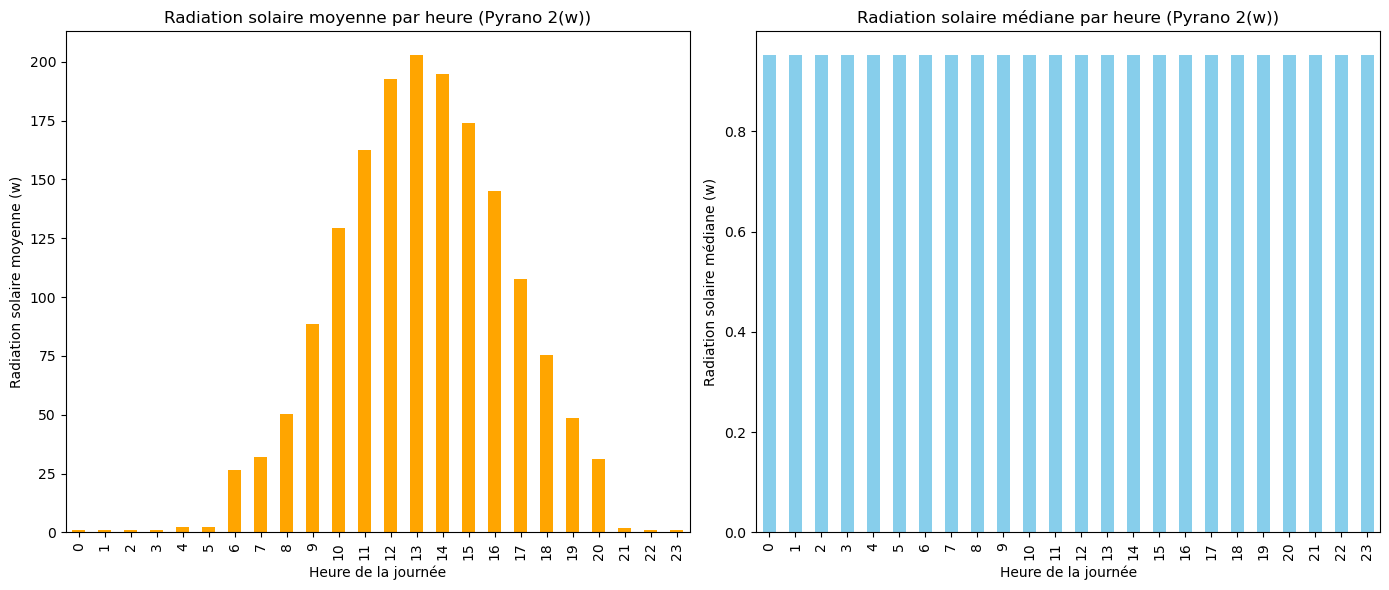

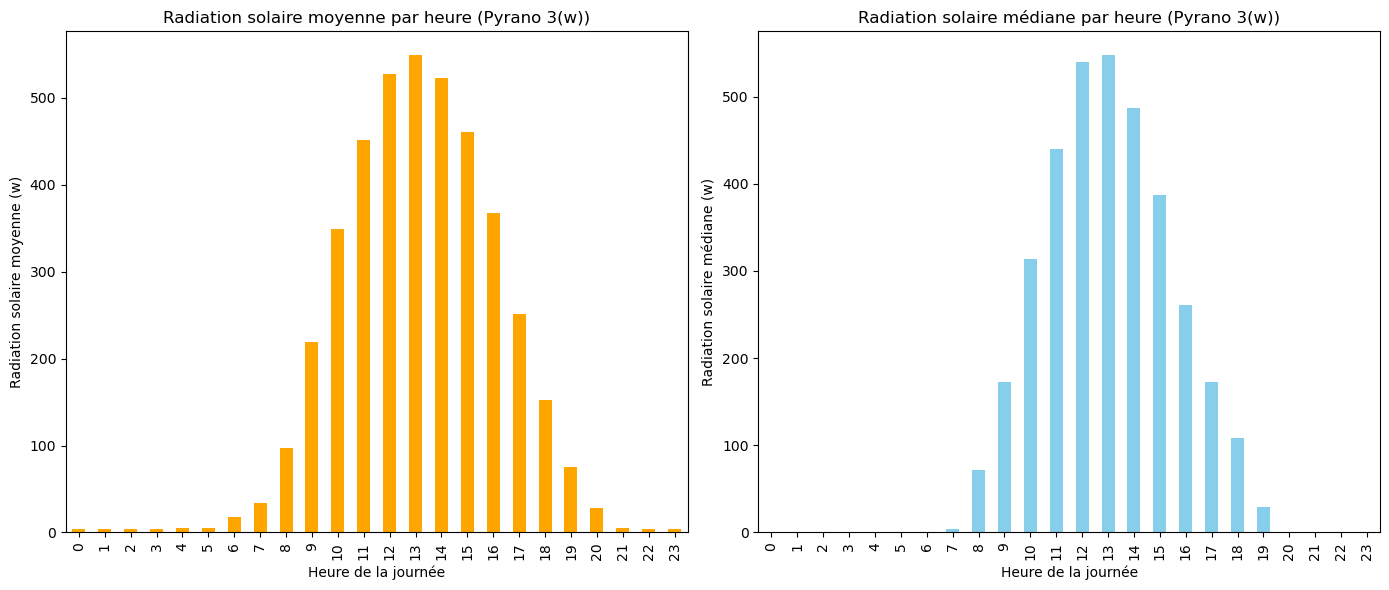

In [27]:
#centrale 1 pyrano 1
hourly_distribution_of_mean_and_median_solar_radiation('FRS00171','Pyrano 1(w)')
#centrale 1 pyrano 2
hourly_distribution_of_mean_and_median_solar_radiation('FRS00171','Pyrano 2(w)')
#centrale 1 pyrano 3
hourly_distribution_of_mean_and_median_solar_radiation('FRS00171','Pyrano 3(w)')

Tandis que la moyenne de l'irradiation solaire par heure semble suivre une distribution normale pour tous les pyranomètres, ce n'est pas le cas pour la médiane par heure. Le médiane par heure des pyranomètres 1 et 3 suit une distribution normale mais celle du pyranomètre 2 suit une distribution uniforme. La différence entre la distribution de la moyenne et de la médiane suggère que le pyranomètre n°2 était juste disfonctionnel sur une partie du temps et après a fonctionné normalement. 

On va garder les valeurs extrèmes des deux autres pyranomètres car elles semblent pas abérrantes.

In [28]:
df[(df['Plant_name'] == 'FRS00171') & (df['Pyrano 2(w)'] == 0.952)]

,Plant_name,Datetime,Pyrano 1(w),Pyrano 2(w),Pyrano 3(w),Production(Wh),Hour
0,FRS00171,2020-01-01 00:05:00,0.466,0.952,0.677,0.0,0
1,FRS00171,2020-01-01 00:10:00,0.457,0.952,0.670,0.0,0
2,FRS00171,2020-01-01 00:15:00,0.463,0.952,0.674,0.0,0
3,FRS00171,2020-01-01 00:20:00,0.455,0.952,0.678,0.0,0
4,FRS00171,2020-01-01 00:25:00,0.463,0.952,0.677,0.0,0
...,...,...,...,...,...,...,...
145564,FRS00171,2021-05-20 12:25:00,628.751,0.952,714.766,6465000.0,12
201363,FRS00171,2021-11-30 06:20:00,0.864,0.952,0.781,0.0,6
201366,FRS00171,2021-11-30 06:35:00,0.870,0.952,0.784,0.0,6
201370,FRS00171,2021-11-30 06:55:00,0.879,0.952,0.781,0.0,6


In [29]:
df[(df['Plant_name'] == 'FRS00171') & (df['Pyrano 2(w)'] > 0.952)]

,Plant_name,Datetime,Pyrano 1(w),Pyrano 2(w),Pyrano 3(w),Production(Wh),Hour
11688,FRS00171,2020-02-10 14:05:00,152.472012,382.995443,172.679223,1.056107e+06,14
11689,FRS00171,2020-02-10 14:10:00,152.472012,382.995443,172.679223,1.056107e+06,14
11690,FRS00171,2020-02-10 14:15:00,152.472012,382.995443,172.679223,1.056107e+06,14
11691,FRS00171,2020-02-10 14:20:00,152.472012,382.995443,172.679223,1.056107e+06,14
11692,FRS00171,2020-02-10 14:25:00,152.472012,382.995443,172.679223,1.056107e+06,14
...,...,...,...,...,...,...,...
210421,FRS00171,2021-12-31 17:10:00,8.496000,10.549000,66.975000,1.000000e+05,17
210422,FRS00171,2021-12-31 17:15:00,6.496000,8.134000,31.964000,0.000000e+00,17
210423,FRS00171,2021-12-31 17:20:00,4.363000,5.193000,6.758000,0.000000e+00,17
210424,FRS00171,2021-12-31 17:25:00,2.574000,2.422000,2.028000,0.000000e+00,17


In [30]:
# Définir les dates de début et de fin
start_date = '2020-01-01 00:05:00'
end_date = '2021-05-20 12:25:00'

mask = (df['Datetime'] >= start_date) & (df['Datetime'] <= end_date)
filtered_data = df[mask]

filtered_data[filtered_data['Pyrano 2(w)'] > 0.952]

,Plant_name,Datetime,Pyrano 1(w),Pyrano 2(w),Pyrano 3(w),Production(Wh),Hour
11688,FRS00171,2020-02-10 14:05:00,152.472012,382.995443,172.679223,1.056107e+06,14
11689,FRS00171,2020-02-10 14:10:00,152.472012,382.995443,172.679223,1.056107e+06,14
11690,FRS00171,2020-02-10 14:15:00,152.472012,382.995443,172.679223,1.056107e+06,14
11691,FRS00171,2020-02-10 14:20:00,152.472012,382.995443,172.679223,1.056107e+06,14
11692,FRS00171,2020-02-10 14:25:00,152.472012,382.995443,172.679223,1.056107e+06,14
...,...,...,...,...,...,...,...
97002,FRS00171,2020-12-02 20:35:00,152.472012,382.995443,172.679223,1.056107e+06,20
97003,FRS00171,2020-12-02 20:40:00,152.472012,382.995443,172.679223,1.056107e+06,20
97004,FRS00171,2020-12-02 20:45:00,152.472012,382.995443,172.679223,1.056107e+06,20
97005,FRS00171,2020-12-02 20:50:00,152.472012,382.995443,172.679223,1.056107e+06,20


Du 01 janvier 2020 jusqu'au 05 mai 2021 (12:25:00) le pyranomètre 2 mesure une valeur constante égale à 0.952 w. Donc on peut uniquement prendre en compte les mesures après le 5 mai 2021 (12:25:00).

#### Centrale 2

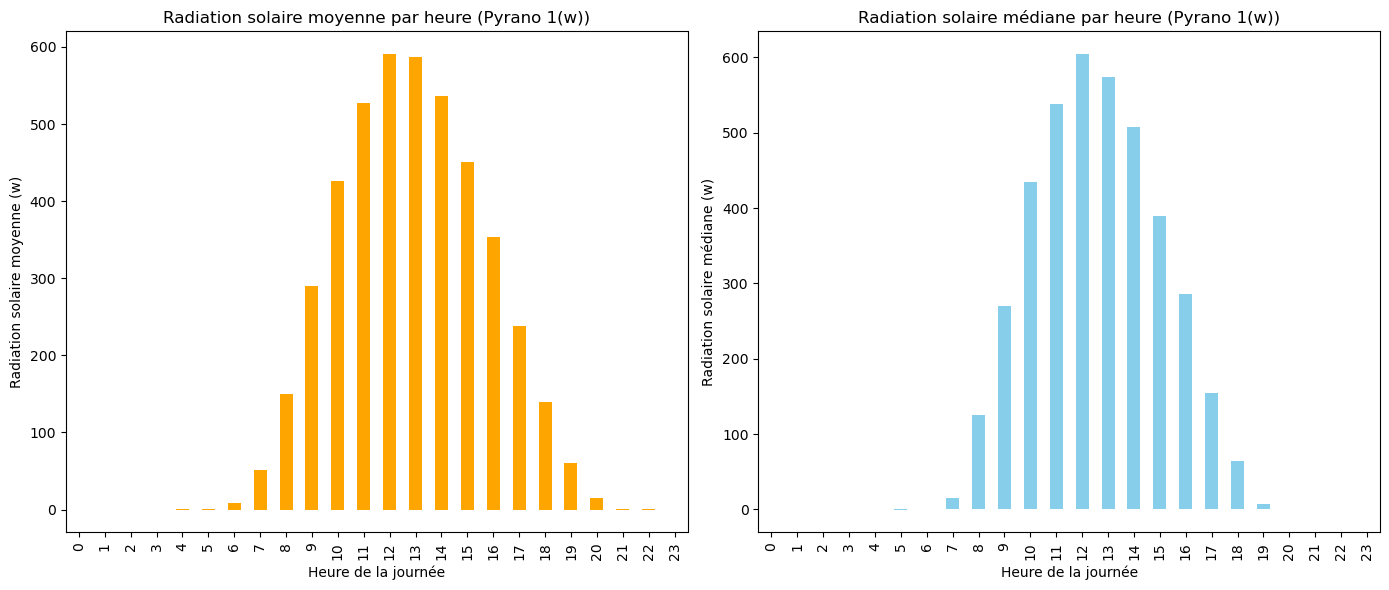

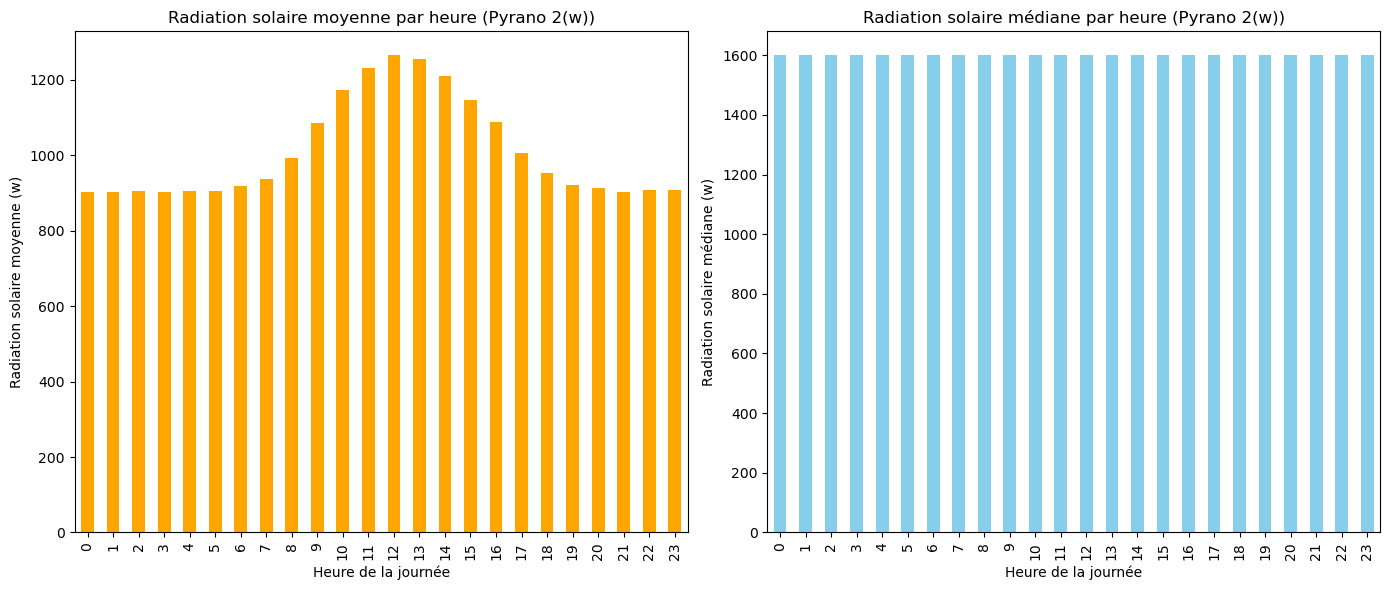

In [31]:
#centrale 1 pyrano 1
hourly_distribution_of_mean_and_median_solar_radiation('FRS00173','Pyrano 1(w)')
#centrale 1 pyrano 2
hourly_distribution_of_mean_and_median_solar_radiation('FRS00173','Pyrano 2(w)')

Pour la centrale 2 la moyenne et la médiane de l'irradiation solaire par heure du pyranomètre 1 suivent une distribution normale. 

Par contre la moyenne et la médiane de l'irradiation solaire par heure du pyranomètre 2 ne suivent pas de distribution normale. Surtout la médiane suit une distribution unforme. Donc de nouveau on a un problème de valeurs constantes qui pourrait indiquer un disfonctionnement du pyranomètre 2. 

In [32]:
df[(df['Plant_name'] == 'FRS00173') & (df['Pyrano 2(w)'] == 1600)]

,Plant_name,Datetime,Pyrano 1(w),Pyrano 2(w),Pyrano 3(w),Production(Wh),Hour
253630,FRS00173,2023-05-30 18:55:00,0.4,1600.0,NaN,0.0,18
253631,FRS00173,2023-05-30 19:00:00,-0.2,1600.0,NaN,0.0,19
253632,FRS00173,2023-05-30 19:05:00,0.4,1600.0,NaN,0.0,19
253633,FRS00173,2023-05-30 19:10:00,0.4,1600.0,NaN,0.0,19
253634,FRS00173,2023-05-30 19:15:00,0.7,1600.0,NaN,0.0,19
...,...,...,...,...,...,...,...
315607,FRS00173,2023-12-31 23:40:00,-0.5,1600.0,NaN,0.0,23
315608,FRS00173,2023-12-31 23:45:00,-0.5,1600.0,NaN,0.0,23
315609,FRS00173,2023-12-31 23:50:00,-0.8,1600.0,NaN,0.0,23
315610,FRS00173,2023-12-31 23:55:00,-0.5,1600.0,NaN,0.0,23


In [33]:
df[(df['Plant_name'] == 'FRS00173') & (df['Pyrano 2(w)'] < 1600)]

,Plant_name,Datetime,Pyrano 1(w),Pyrano 2(w),Pyrano 3(w),Production(Wh),Hour
210504,FRS00173,2023-01-01 00:05:00,-0.500000,0.638000,NaN,0.000000e+00,0
210505,FRS00173,2023-01-01 00:10:00,-0.800000,0.634000,NaN,0.000000e+00,0
210506,FRS00173,2023-01-01 00:15:00,-0.800000,0.644000,NaN,0.000000e+00,0
210507,FRS00173,2023-01-01 00:20:00,-0.800000,0.646000,NaN,0.000000e+00,0
210508,FRS00173,2023-01-01 00:25:00,-0.800000,0.649000,NaN,0.000000e+00,0
...,...,...,...,...,...,...,...
301573,FRS00173,2023-11-13 06:10:00,152.472012,382.995443,NaN,1.056107e+06,6
301574,FRS00173,2023-11-13 06:15:00,152.472012,382.995443,NaN,1.056107e+06,6
301575,FRS00173,2023-11-13 06:20:00,152.472012,382.995443,NaN,1.056107e+06,6
301576,FRS00173,2023-11-13 06:25:00,152.472012,382.995443,NaN,1.056107e+06,6


Du 30 mai 2023 (18:55:00) au 01 janvier 2024 le pyranomètre 2 mesure une valeur contante égale à 1600 w. Donc pour la suite de notre analyse, on peut uniquement prendre en compte les mesures avant le 30 mai 2023 (18:55:00).

On doit appliquer un filtre pour le pyrano 2 pour exclure les valeurs constantes 

In [34]:
 valid_dates_pyrano2 = (df['Datetime'] > '2021-05-05 12:25:00') & (df['Datetime'] < '2023-05-30 18:55:00')

#### Pourcentage des données abérrantes

In [35]:
def calculate_percentages_of_outliers(data):
    results = {}

    # Définir la période nocturne (entre 21h et 6h)
    night_time = (data['Datetime'].dt.hour >= 21) | (data['Datetime'].dt.hour < 6)
    day_time = (data['Datetime'].dt.hour < 21) & (data['Datetime'].dt.hour >= 6)

    for column in data.columns:
        if column in ['Pyrano 1(w)', 'Pyrano 2(w)', 'Pyrano 3(w)', 'Production(Wh)']:
            total_count = len(data[column])
            
            # Pourcentage de valeurs négatives
            negative_percentage = (data[column] < 0).sum() / total_count * 100
    
            # Pourcentage de valeurs positives pendant la nuit
            positive_night_percentage = ((data[column] > 0) & night_time).sum() / total_count * 100
            
             # Pourcentage de valeurs constantes de la production exclues la nuit
            contant_percentage_0_night_excluded = ((data[column] == 0) & day_time).sum() / total_count * 100


            # Enregistrer les résultats pour chaque colonne
            results[column] = {
                'Negative Percentage': negative_percentage,
                'Positive Night Time Percentage': positive_night_percentage,
                'Constant Percentage (0)': contant_percentage_0_night_excluded
            }

    # Calcul spécifique pour Pyrano 2(w)
    if 'Pyrano 2(w)' in data.columns:
        total_count_pyrano2 = len(data['Pyrano 2(w)'])
        
        # Définir les périodes constantes pour Pyrano 2
        constant_percentage_0952 = (data['Pyrano 2(w)'] == 0.952).sum() / total_count_pyrano2 * 100
        constant_percentage_1600 = (data['Pyrano 2(w)'] == 1600).sum() / total_count_pyrano2 * 100

        results['Pyrano 2(w)']['Constant Percentage (0.952)'] = constant_percentage_0952
        results['Pyrano 2(w)']['Constant Percentage (1600)'] = constant_percentage_1600

    return results

# Appliquer la fonction et afficher les résultats
percentages = calculate_percentages_of_outliers(df[df['Plant_name'] == 'FRS00171'])
print('Centrale 1')
for column, values in percentages.items():
    print(f"\n{column}:")
    for metric, value in values.items():
        if value is not None:
            print(f"{metric}: {value:.2f}%")
print('-----------------------------------------')
percentages = calculate_percentages_of_outliers(df[df['Plant_name'] == 'FRS00173'])  
print('\nCentrale 2')
for column, values in percentages.items():
    print(f"\n{column}:")
    for metric, value in values.items():
        if value is not None:
            print(f"{metric}: {value:.2f}%")


Centrale 1

Pyrano 1(w):
Negative Percentage: 5.09%
Positive Night Time Percentage: 30.40%
Constant Percentage (0): 0.00%

Pyrano 2(w):
Negative Percentage: 0.00%
Positive Night Time Percentage: 34.99%
Constant Percentage (0): 0.02%
Constant Percentage (0.952): 64.34%
Constant Percentage (1600): 0.00%

Pyrano 3(w):
Negative Percentage: 0.00%
Positive Night Time Percentage: 35.10%
Constant Percentage (0): 0.00%

Production(Wh):
Negative Percentage: 0.00%
Positive Night Time Percentage: 0.16%
Constant Percentage (0): 17.74%
-----------------------------------------

Centrale 2

Pyrano 1(w):
Negative Percentage: 28.39%
Positive Night Time Percentage: 16.88%
Constant Percentage (0): 0.00%

Pyrano 2(w):
Negative Percentage: 0.00%
Positive Night Time Percentage: 36.48%
Constant Percentage (0): 0.00%
Constant Percentage (0.952): 0.00%
Constant Percentage (1600): 56.40%

Pyrano 3(w):
Negative Percentage: 0.00%
Positive Night Time Percentage: 0.00%
Constant Percentage (0): 0.00%

Production(Wh)

### Traitement des données abérrantes

Maintenant qu'on sait quelles périodes du pyrano 2 on peut exclure de notre analyse, on peut procéder au remplacement des valeurs nocturnes par 0 et des valeurs négatives diurnes par les valeurs positives les plus proches. 

In [36]:
def replace_nocturnal_values_with_zero(data):
    # Définir la période nocturne (entre 21h et 6h)
    night_time = (data['Datetime'].dt.hour >= 21) | (data['Datetime'].dt.hour < 6)
    valid_dates_pyrano2 = (data['Datetime'] > '2021-05-05 12:25:00') & (data['Datetime'] < '2023-05-30 18:55:00')
    
    # Remplacer les valeurs nocturnes par 0 pour Pyrano 1 et Production sans filtrage de date
    data.loc[night_time, ['Pyrano 1(w)', 'Production(Wh)']] = 0
    
    # Remplacer les valeurs nocturnes par 0 pour Pyrano 3 uniquement pour la centrale 1 (FRS00171)
    pyrano3 = (data['Plant_name'] == 'FRS00171')
    data.loc[night_time & pyrano3, 'Pyrano 3(w)'] = 0
    
    # Appliquer le filtre de date uniquement à Pyrano 2
    data.loc[night_time & valid_dates_pyrano2, 'Pyrano 2(w)'] = 0
    
    return data

# Appliquer la fonction sur le DataFrame
df = replace_nocturnal_values_with_zero(df)

In [37]:
def replace_negative_daytime_values(data):
    # Remplacement des valeurs négatives diurnes par la valeur positive la plus proche
    for column in ['Pyrano 1(w)', 'Pyrano 2(w)', 'Pyrano 3(w)', 'Production(Wh)']:
        data.loc[data[column] < 0, column] = np.nan
        data[column] = data[column].fillna(method='ffill').fillna(method='bfill')

    return data

# Appliquer la fonction sur le DataFrame
df = replace_negative_daytime_values(df)

### Recap des défauts du jeu de données

1. Il fallait formater la colonne date.
2. Il y avait des doublons de dates avec aucune mesure captée (des valeurs NaN).
3. Il avait des données manquantes autour de 5% pour chaque pyranomètre et la production.
4. Il avait plusieurs valeurs abérrantes: 
    - des valeurs de l'irradiation solaire négative 
    - des valeurs de l'irradiation solaire positive la nuit 
    - des valeurs constantes sur plusieurs mois mesurées par le pyranomètre 2 des deux centrale
5. La production du mois de juin 2020 de la centrale 1 est extrêment basse. 

### Ramener tout le jeu de données au pas horaire

In [38]:
hourly_data = df.resample('H', on='Datetime').agg({
    'Plant_name': 'first',
    'Pyrano 1(w)': 'mean',
    'Pyrano 2(w)': 'mean',
    'Pyrano 3(w)': 'mean',
    'Production(Wh)': 'sum'
}).reset_index()

In [39]:
hourly_data[(hourly_data['Datetime'] > '2021-05-20 12:00:00') & (hourly_data['Datetime'] < '2023-05-30 17:00:00')]

,Datetime,Plant_name,Pyrano 1(w),Pyrano 2(w),Pyrano 3(w),Production(Wh)
12133,2021-05-20 13:00:00,FRS00171,899.899667,977.408417,973.957583,99932000.0
12134,2021-05-20 14:00:00,FRS00171,931.232083,1025.352000,1017.789417,101836000.0
12135,2021-05-20 15:00:00,FRS00171,882.392083,954.848917,942.812750,97495000.0
12136,2021-05-20 16:00:00,FRS00171,726.559167,783.076750,767.582167,80765000.0
12137,2021-05-20 17:00:00,FRS00171,454.399667,481.907500,472.281750,50940000.0
...,...,...,...,...,...,...
29892,2023-05-30 12:00:00,FRS00173,864.275000,1095.260500,0.000000,19175000.0
29893,2023-05-30 13:00:00,FRS00173,975.541667,1213.782500,0.000000,19187000.0
29894,2023-05-30 14:00:00,FRS00173,893.341667,1162.743667,0.000000,20538000.0
29895,2023-05-30 15:00:00,FRS00173,731.100000,896.225583,0.000000,16352000.0


### Matrices de corrélation

In [40]:
def calculate_correlation_matrices(data):
    results = {}

    # Exclure les périodes constantes pour Pyrano 2
    valid_periods = (data['Datetime'] > '2021-05-05 12:00:00') & (data['Datetime'] < '2023-05-30 18:00:00')
    
    # Séparer les données pour chaque centrale
    data_central_1 = data[data['Plant_name'] == 'FRS00171']
    data_central_2 = data[data['Plant_name'] != 'FRS00171']

    # Matrices de corrélation centrale 1
    results['Central 1 (all pyranos) over valid time frame'] = data_central_1[valid_periods][['Pyrano 1(w)', 'Pyrano 2(w)', 'Pyrano 3(w)', 'Production(Wh)']].corr()
    results['Central 1 (Pyrano 1 and 3) over whole time frame'] = data_central_1[['Pyrano 1(w)', 'Pyrano 3(w)', 'Production(Wh)']].corr()
    
    # Matrice de corrélation centrale 2
    results['Central 2 (all pyranos) over valid time frame'] = data_central_2[valid_periods][['Pyrano 1(w)', 'Pyrano 2(w)', 'Production(Wh)']].corr()
    results['Central 2 (Pyrano 1) over whole time frame'] = data_central_2[['Pyrano 1(w)', 'Production(Wh)']].corr()
    
    return results

# Calculer les matrices de corrélation pour chaque configuration
correlation_matrices = calculate_correlation_matrices(hourly_data)

# Afficher les matrices de corrélation
for key, matrix in correlation_matrices.items():
    print(f"\n{key}:\n{matrix}")


Central 1 (all pyranos) over valid time frame:
                Pyrano 1(w)  Pyrano 2(w)  Pyrano 3(w)  Production(Wh)
Pyrano 1(w)        1.000000     0.906942     0.969729        0.962458
Pyrano 2(w)        0.906942     1.000000     0.942040        0.928539
Pyrano 3(w)        0.969729     0.942040     1.000000        0.990115
Production(Wh)     0.962458     0.928539     0.990115        1.000000

Central 1 (Pyrano 1 and 3) over whole time frame:
                Pyrano 1(w)  Pyrano 3(w)  Production(Wh)
Pyrano 1(w)        1.000000     0.973438        0.919089
Pyrano 3(w)        0.973438     1.000000        0.946853
Production(Wh)     0.919089     0.946853        1.000000

Central 2 (all pyranos) over valid time frame:
                Pyrano 1(w)  Pyrano 2(w)  Production(Wh)
Pyrano 1(w)        1.000000     0.979655        0.963705
Pyrano 2(w)        0.979655     1.000000        0.988604
Production(Wh)     0.963705     0.988604        1.000000

Central 2 (Pyrano 1) over whole time frame:
  

/tmp/ipykernel_160991/2797849332.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results['Central 1 (all pyranos) over valid time frame'] = data_central_1[valid_periods][['Pyrano 1(w)', 'Pyrano 2(w)', 'Pyrano 3(w)', 'Production(Wh)']].corr()
/tmp/ipykernel_160991/2797849332.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results['Central 2 (all pyranos) over valid time frame'] = data_central_2[valid_periods][['Pyrano 1(w)', 'Pyrano 2(w)', 'Production(Wh)']].corr()


#### Commentaire

La correlation entre deux variables décrit comment ils évoluent ensemble. Dans un premier temps on regarde comment les pyranomètres sont corrélés entre eux puis comment ils sont corrélés à la production. 

*Centrale 1:*

Pyrano 1, 2, et 3 sont fortement corrélés entre eux, avec des coefficients de corrélation entre 0.91 et 0.97. Cela signifie qu'ils capturent de manière cohérente les variations de l’ensoleillement. Vue la correlation élévée entre les pyranomètres c'est tout à fait légitime de prendre en compte qu'un seul pyranomètre pour le performance ratio.

Les corrélations entre chaque pyranomètre et la production sont élevées, notamment pour Pyrano 3 (0.99). Cela indique que la production de la centrale est bien influencée par les mesures de l'irradiation captées par ces pyranomètres, en particulier Pyrano 3, qui semble être un indicateur clé. Donc on va utiliser celui-ci pour le calcul du pr. 

*Centrale 2:*

Pyrano 1 et 2 sont fortement corrélés entre eux, avec des coefficients de corrélation autour de 0.97. Cela signifie qu'ils capturent de manière cohérente les variations de l’ensoleillement. Encore une fois vue la correlation élévée entre les pyranomètres c'est tout à fait légitime de prendre en compte qu'un seul pyranomètre pour le performance ratio.

Les corrélations entre chaque pyranomètre et la production sont élevées, mais vue que seule le pyranomètre 1 fonctionne correctement sur toute la période, on va utiliser celui-ci pour notre analyse. 

### Calcul du Performance Ratio

Le Performance Ratio (pr) mesure l'efficacité et la performance d'une centrale solaire. Le pr se calcule de manière suivante: 

pr = production / (irradiation solaire * puissance crête)

La valeur du pr est comprise entre 0 et 1. Plus la valeur se rapproche de 1, plus la centrale est performante.

On aimerait bien connaître le pr au pas mensuel.

In [41]:
#Transformation de la puissance crête (kW) en W de la centrale 1 et 2
puissance_crete_w_1 =  10377.6 * 1000
puissance_crete_w_2 = 2207.48 * 1000

In [47]:
def calculate_monthly_pr(data, pyrano, puissance_crete):
    # Mesure d'irradiation 
    data['Irradiation(Wh)'] = data[pyrano]
    
    # Aggrégation de la donnée au pas mensuel
    monthly_data = data.resample('M', on='Datetime').agg({
        'Production(Wh)': 'sum',  # Somme de la production sur le mois
        'Irradiation(Wh)': 'sum'  # Somme de l'énergie solaire reçue sur le mois
    })

    # Calculer le Performance Ratio (PR)
    monthly_data['PR'] = (monthly_data['Production(Wh)']) / (monthly_data['Irradiation(Wh)'] * puissance_crete)

    return monthly_data[['Production(Wh)', 'Irradiation(Wh)', 'PR']]

centrale_1 = hourly_data[hourly_data['Plant_name'] == 'FRS00171']
centrale_2 = hourly_data[hourly_data['Plant_name'] == 'FRS00173']

centrale_1_daytime = centrale_1[(centrale_1['Datetime'].dt.hour >= 6) & (centrale_1['Datetime'].dt.hour < 21)]
centrale_2_daytime = centrale_2[(centrale_2['Datetime'].dt.hour >= 6) & (centrale_2['Datetime'].dt.hour < 21)]


monthly_pr_data_1 = calculate_monthly_pr(centrale_1_daytime, 'Pyrano 3(w)',puissance_crete_w_1)
monthly_pr_data_2 = calculate_monthly_pr(centrale_2_daytime, 'Pyrano 1(w)',puissance_crete_w_2)

# Afficher les résultats du PR mensuel
display(monthly_pr_data_1.round(4))
display(monthly_pr_data_2.round(4))

/tmp/ipykernel_160991/1606971965.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Irradiation(Wh)'] = data[pyrano]
/tmp/ipykernel_160991/1606971965.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Irradiation(Wh)'] = data[pyrano]


,Production(Wh),Irradiation(Wh),PR
Datetime,,,
2020-01-31,6.588564e+09,62309.0672,0.0102
2020-02-29,9.418534e+09,88177.8778,0.0103
2020-03-31,1.273816e+10,123175.6284,0.0100
2020-04-30,1.647307e+10,154582.7872,0.0103
2020-05-31,1.805076e+10,193953.3682,0.0090
2020-06-30,9.507096e+08,156403.1551,0.0006
2020-07-31,1.398924e+10,146946.3298,0.0092
2020-08-31,1.857051e+10,180894.1099,0.0099
2020-09-30,1.646535e+10,158034.3742,0.0100


,Production(Wh),Irradiation(Wh),PR
Datetime,,,
2023-01-31,2.210671e+09,60154.3138,0.0166
2023-02-28,2.823937e+09,80669.2917,0.0159
2023-03-31,4.014702e+09,137948.4750,0.0132
2023-04-30,4.419510e+09,174987.1000,0.0114
2023-05-31,3.853180e+09,176462.8500,0.0099
2023-06-30,3.953370e+09,186131.1667,0.0096
2023-07-31,5.055121e+09,239447.8417,0.0096
2023-08-31,4.718453e+09,199205.6423,0.0107
2023-09-30,3.905294e+09,146743.2662,0.0121


Les performances ratio (pr) sont très bas donc du coup faut re-investiger le pré-traitement pour savoir si c'est normal. 

### Pistes de correction 

#### Un jour et un mois en détail

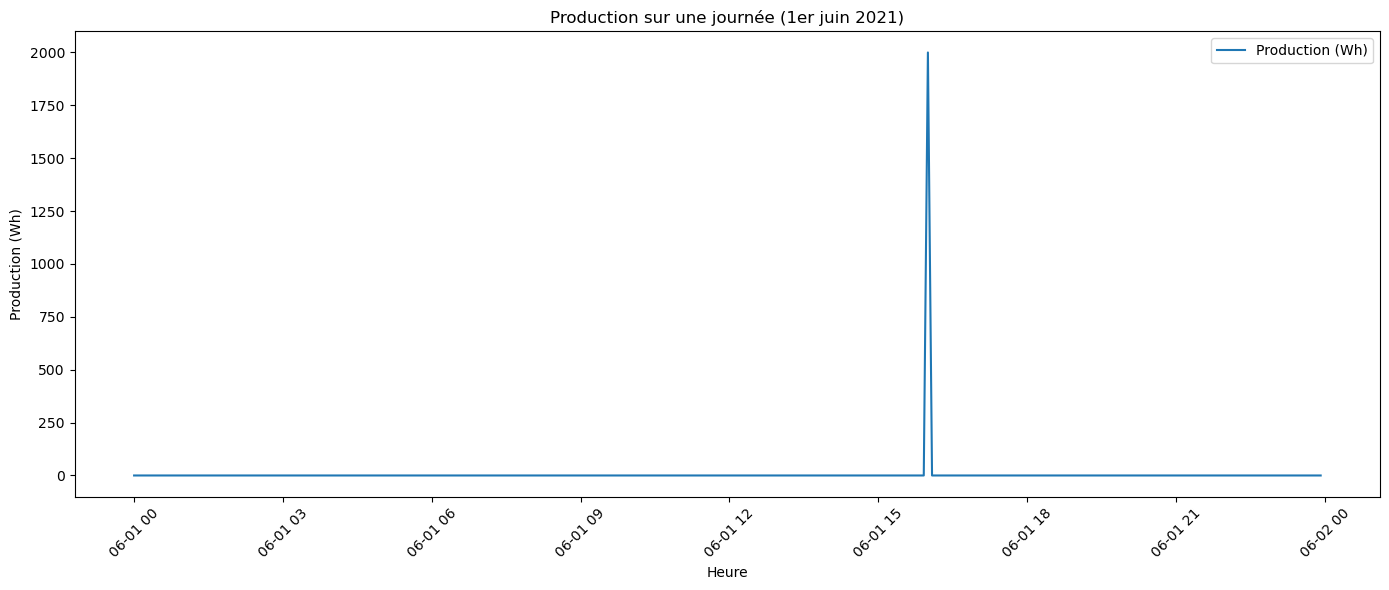

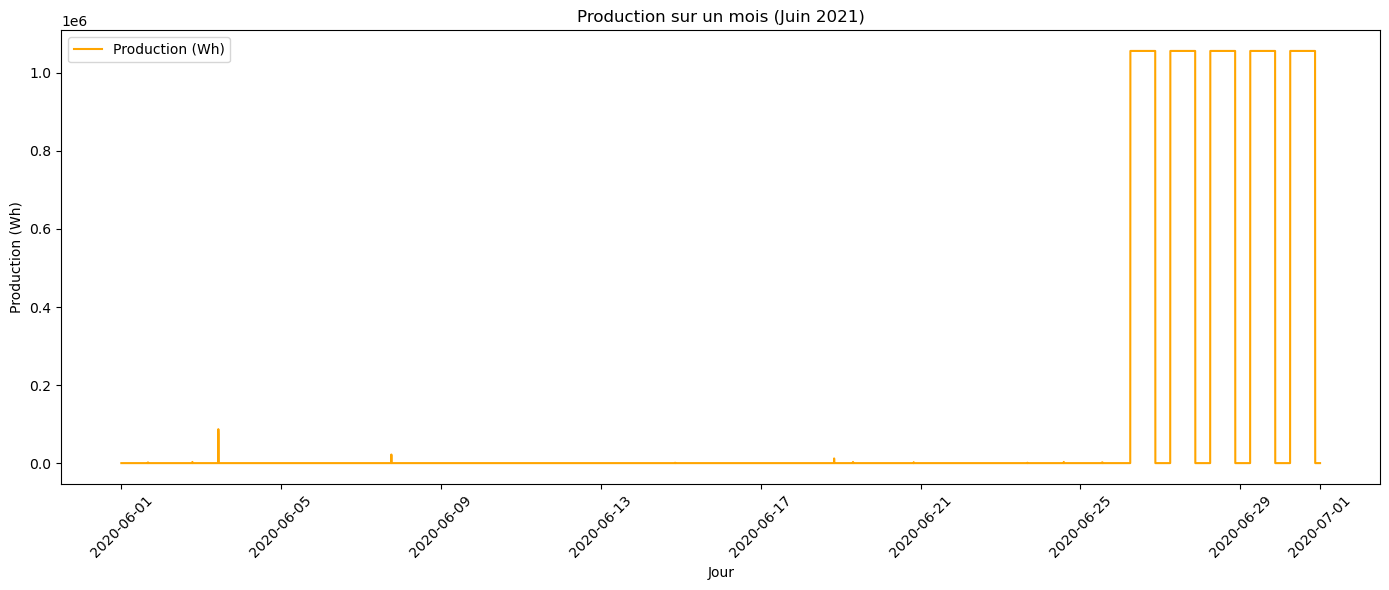

In [43]:
# Filtrer les données pour un jour spécifique (par exemple, 1er juin 2021)
day_data = df[(df['Datetime'] >= '2020-06-01') & (df['Datetime'] < '2020-06-02')]

# Filtrer les données pour un mois spécifique (par exemple, juin 2021)
month_data = df[(df['Datetime'] >= '2020-06-01') & (df['Datetime'] < '2020-07-01')]

# Tracer la production pour une journée
plt.figure(figsize=(14, 6))
plt.plot(day_data['Datetime'], day_data['Production(Wh)'], label='Production (Wh)')
plt.title('Production sur une journée (1er juin 2021)')
plt.xlabel('Heure')
plt.ylabel('Production (Wh)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Tracer la production pour un mois
plt.figure(figsize=(14, 6))
plt.plot(month_data['Datetime'], month_data['Production(Wh)'], label='Production (Wh)', color='orange')
plt.title('Production sur un mois (Juin 2021)')
plt.xlabel('Jour')
plt.ylabel('Production (Wh)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#### Boxplot production 


Centrale 1 Jour


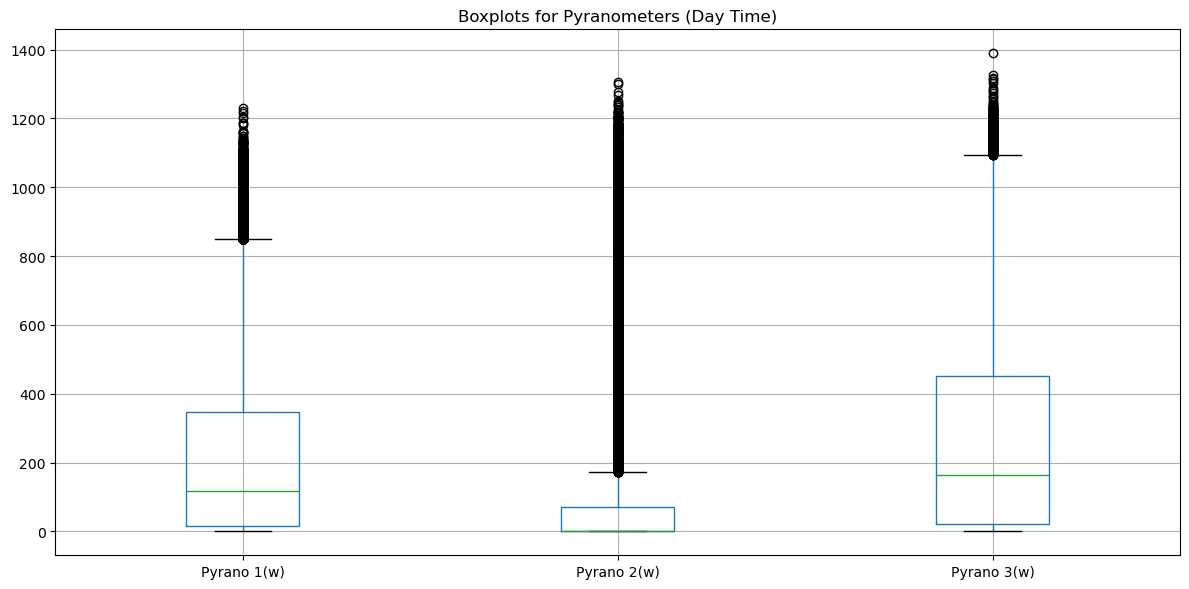

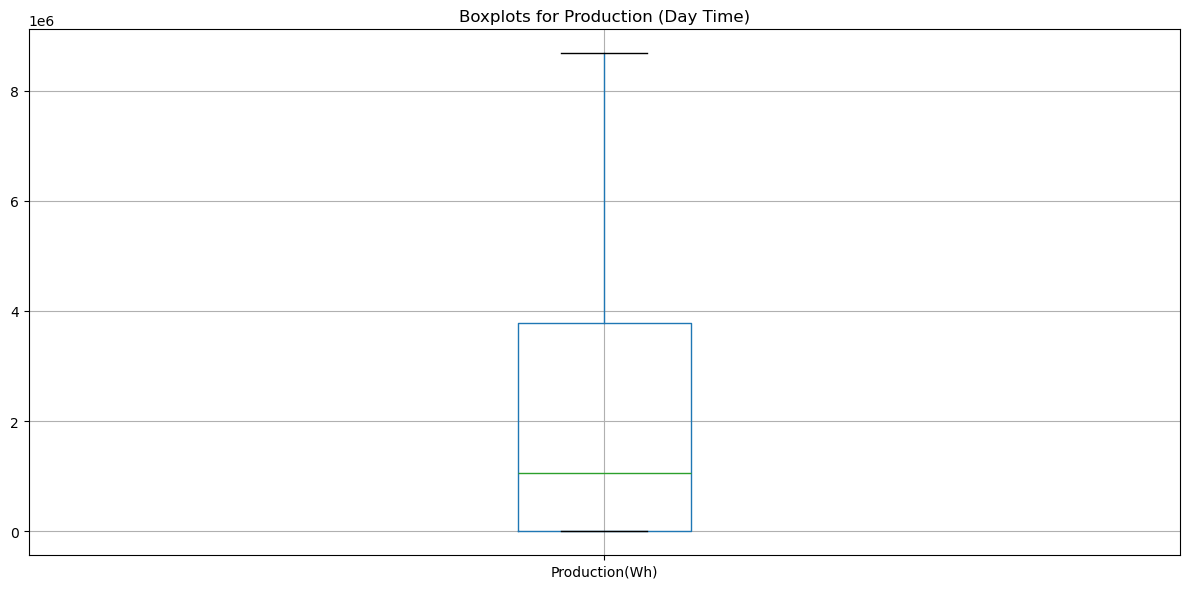

In [44]:
print("\nCentrale 1 Jour")
draw_boxplots_for_each_variable(df[df['Plant_name'] == 'FRS00171'], 3,'Day Time')


Centrale 2 Jour


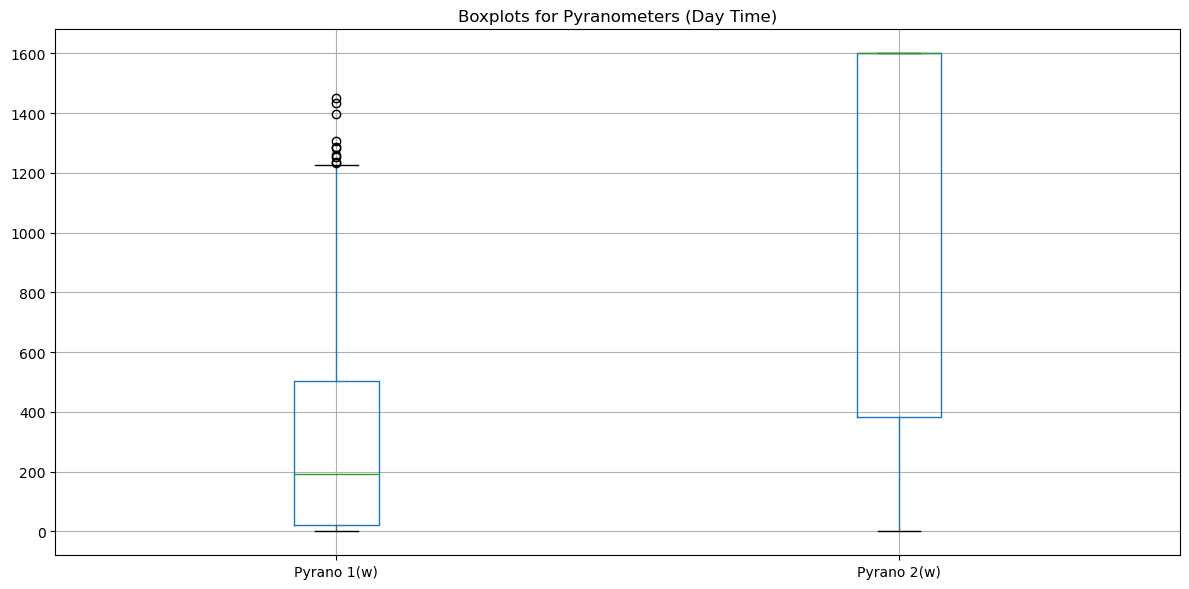

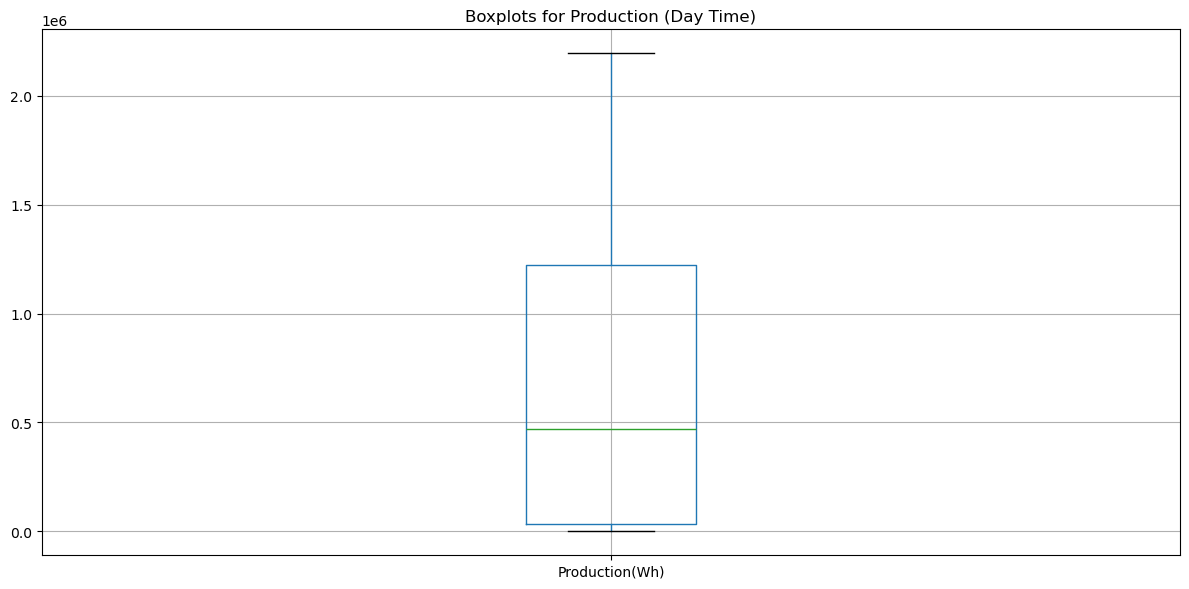

In [45]:
print("\nCentrale 2 Jour")
draw_boxplots_for_each_variable(df[df['Plant_name'] == 'FRS00173'], 2,'Day Time')

On peut constater que le quart inférieur des données (25 % des valeurs les plus basses) correspond à une production près de 0 Wh, ce qui est représenté par le bord inférieur de la boîte collé à l'axe horizontal.

On peut se demander si cette proportion de 25 % de valeurs nulles dans la production est due à des périodes de faible ensoleillement (par exemple, tôt le matin ou tard le soir), ou bien à des interruptions ou anomalies dans le fonctionnement de l’installation. 

Du coup il faut vérifier si ces valeurs se concentrent pendant des plages horaires précises. 